We check how much of the variance is explained away by the seasonal pattern in the GluonTS data sets (after removing the MA). This is important since the previous try on the gluonts data set seems to have been on a data set where there's more noise than seasonal pattern - which can produce spurious results. 

Here, 
- we first revise the trend-cycle decomposition to use the SMA with period * 2.
- we compute the naive seasonal decomposition and check the contribution of the seasonal component to each time series. we find this varies across different time series.
- we take some examples that have high variance explained by the seasonal component, and compare methods.
- in sample, the tensor method seems to be doing better in RMSE.
- we also verify with mean absolute deviation.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorly as tl
from gluonts.dataset.util import to_pandas
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from scipy import interpolate
from scipy.stats import linregress
from scipy.fftpack import rfft, irfft, dct, idct
from tensorly.decomposition import parafac, tucker

from tens_utils import (
    get_gluonts_dataset,
    multifold,
    repeat,
    dct_dft_errors,
    tensor_errors,
    dct_dft_errors_test,
    tensor_errors_test,
    plot_comparison,
    mad,
)

In [2]:
train_datas, test_datas, lens, freqs = get_gluonts_dataset(dataset_name="electricity")

INFO:root:using dataset already processed in path /Users/caner/.mxnet/gluon-ts/datasets/electricity.


21044    321
dtype: int64
H    321
dtype: int64


### Find the contribution of the seasonal component for each of the gluonts time series

In [3]:
def trend_cycle_decompose(df: pd.Series, w: int, df_train=None):
    assert type(df) == pd.core.series.Series
    assert type(w) == int
    assert w > 1
    
    dfi = df.interpolate("linear")
    trend_cycle = dfi.rolling(w).mean().fillna(method="bfill")
    residual = dfi - trend_cycle
    
    return trend_cycle, residual

In [4]:
def naive_seasonal_decompose(df: pd.Series, w: int, df_train=None):
    a = np.array(df)
    new_len_a = (len(a) // w) * w
    
    seasonal = multifold(a[:new_len_a], [w]).mean(0)
    seas_effect = pd.Series(
        repeat(seasonal, len(a) // w + 1)[:len(a)], index=df.index
    )
    
    return seas_effect, df - seas_effect

In [5]:
def analyze_and_plot(df, period: int):
    tc, res_tc = trend_cycle_decompose(df, period * 2)
    seas, res_seas = naive_seasonal_decompose(res_tc, period * 7)

    r2 = np.square(seas).sum() / np.square(res_tc).sum()
    
    f, axes = plt.subplots(3, figsize=(8, 5), sharex=True)
    for ax_, title, obj in zip(
        axes, 
        ["Trend-cycle", "Seasonal", "Residual"],
        [tc, seas, res_seas]
    ):
        ax_.plot(obj)
        ax_.set(title=title)
        
    f.suptitle(f"R^2: {r2: .2f}")
    plt.show()

0


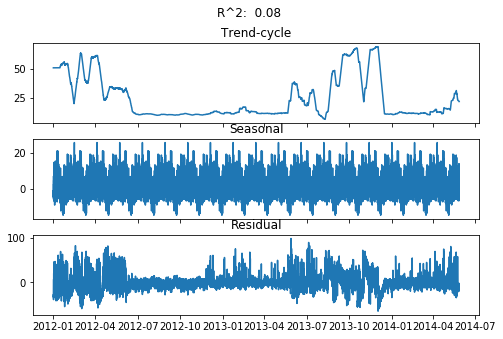

1


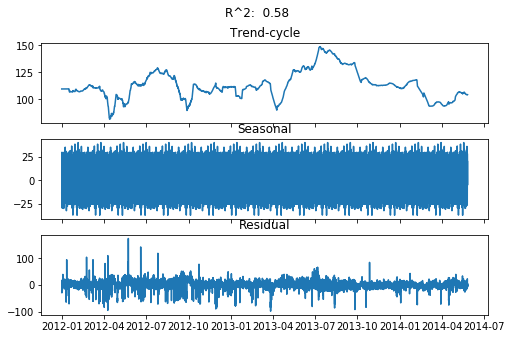

2


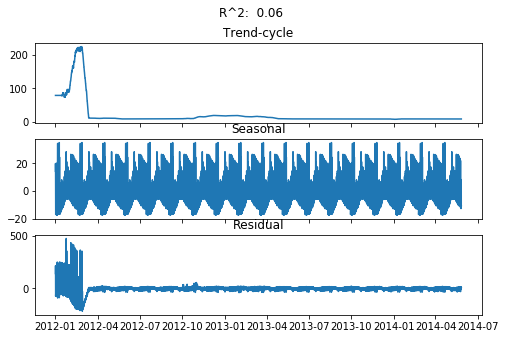

3


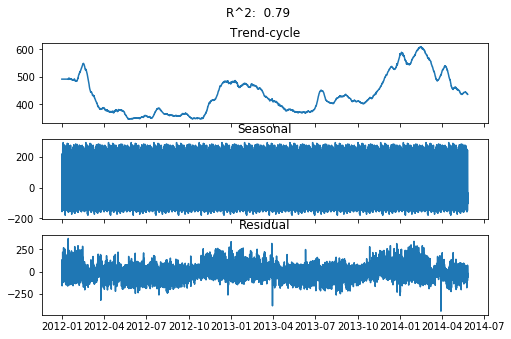

4


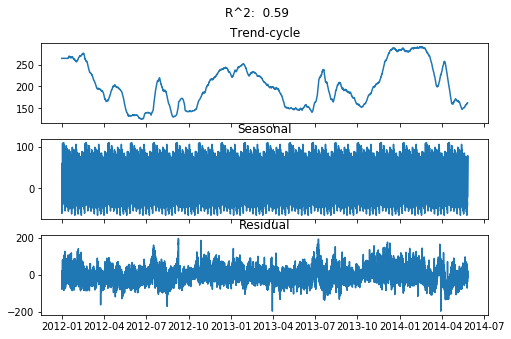

5


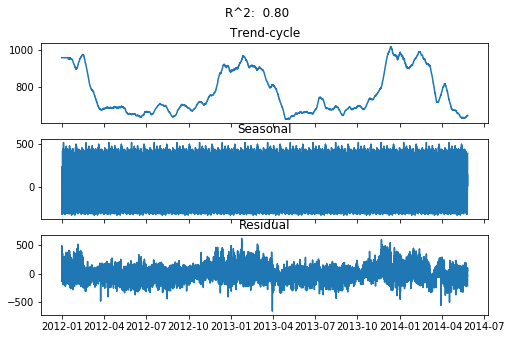

6


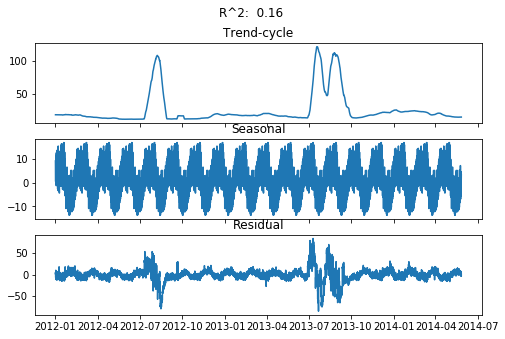

7


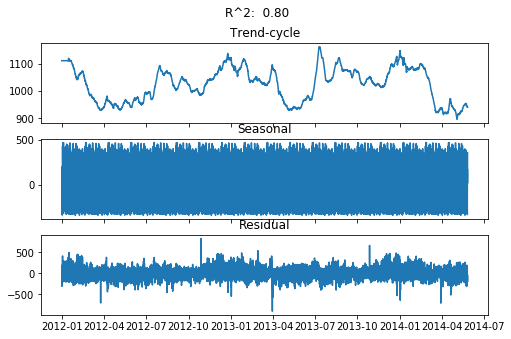

8


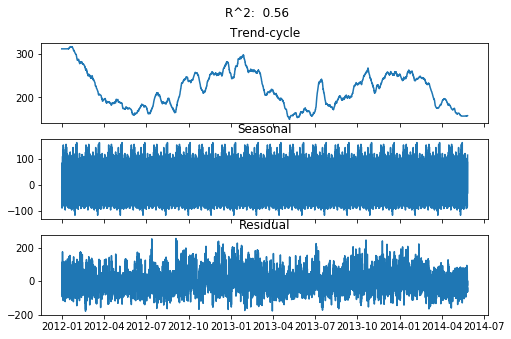

9


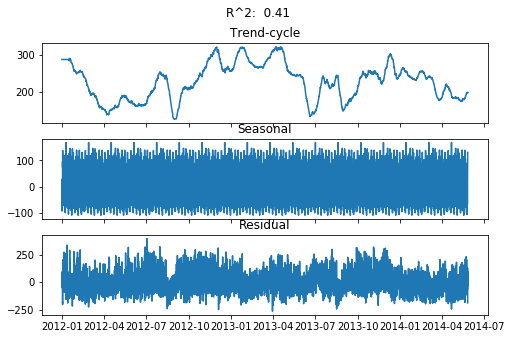

10


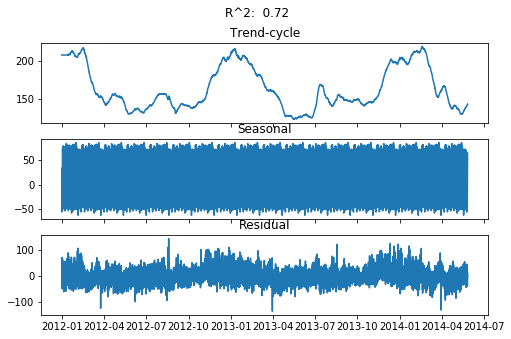

11


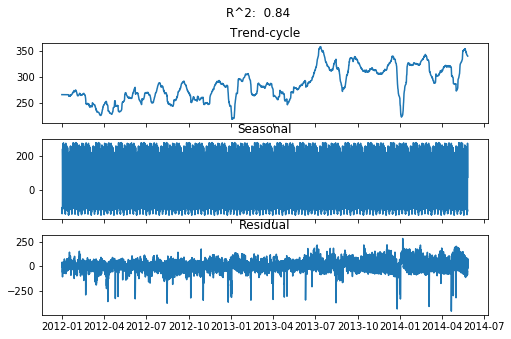

12


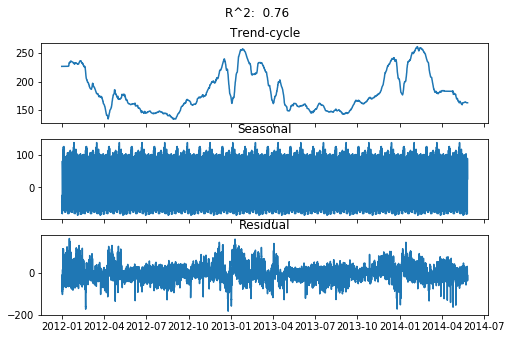

13


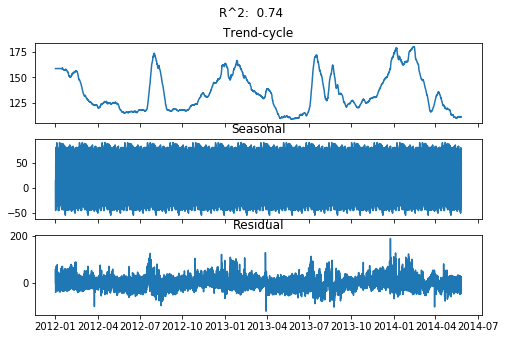

14


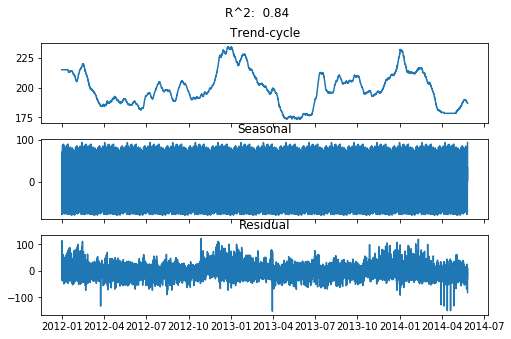

15


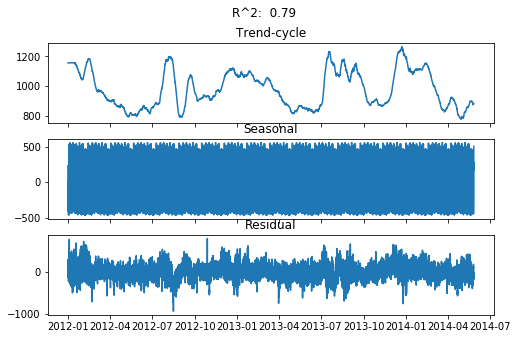

16


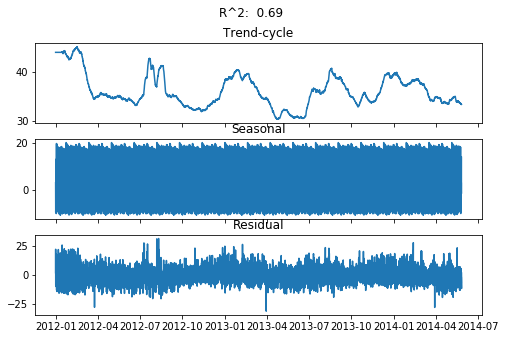

17


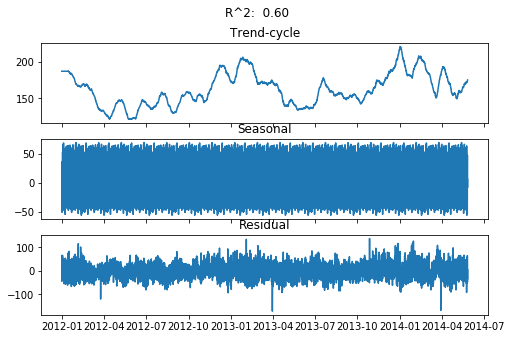

18


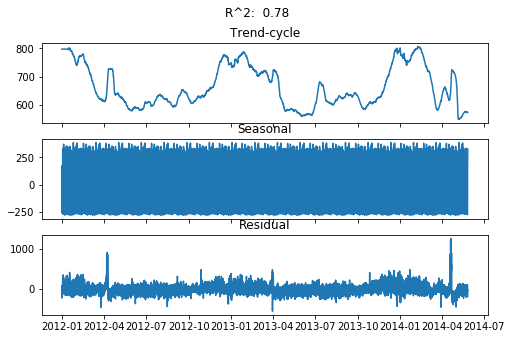

19


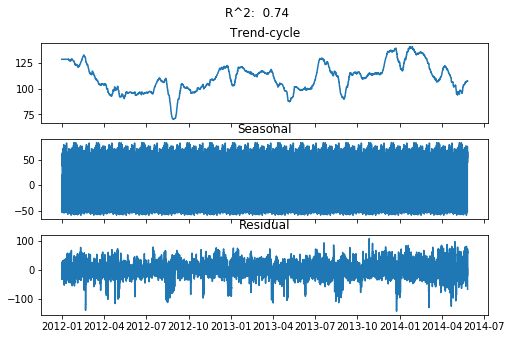

20


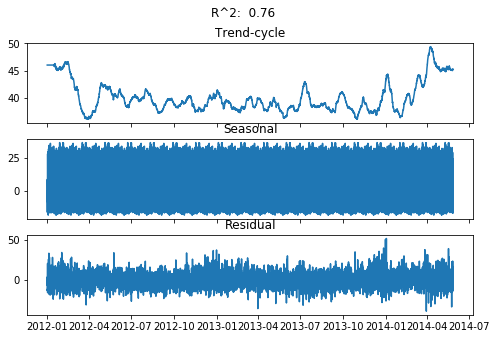

21


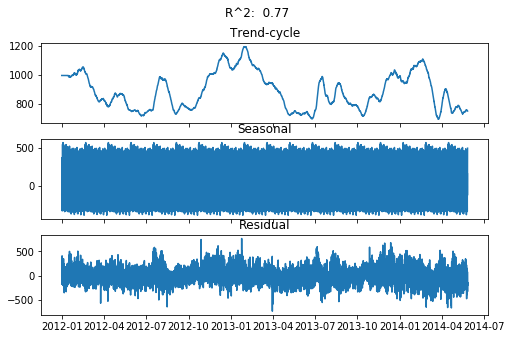

22


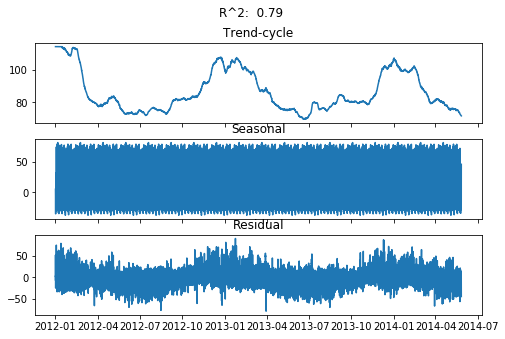

23


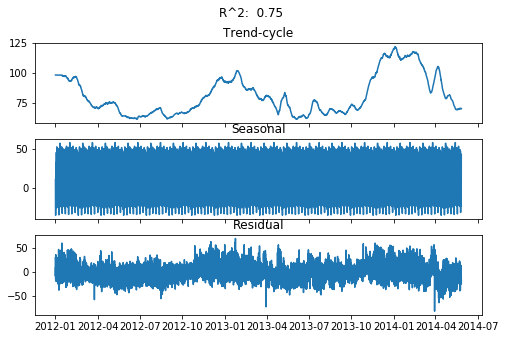

24


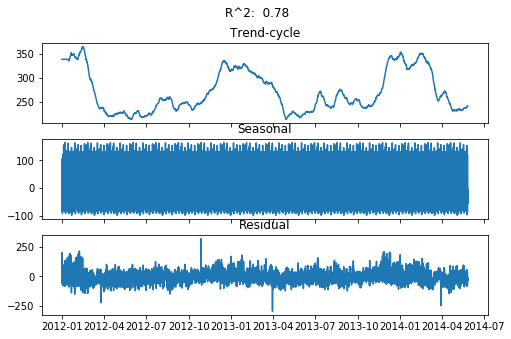

25


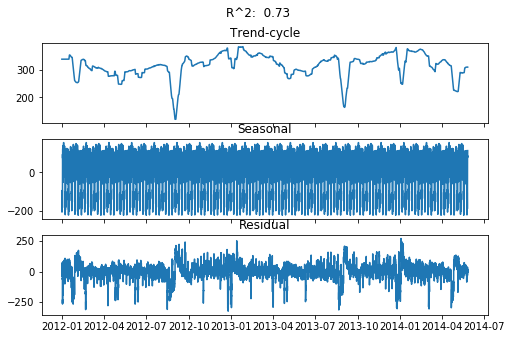

26


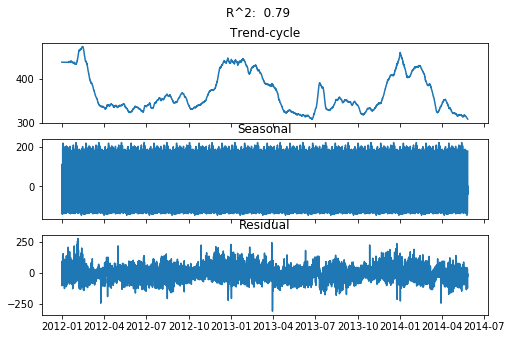

27


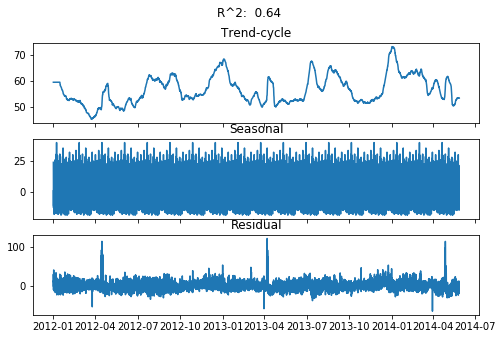

28


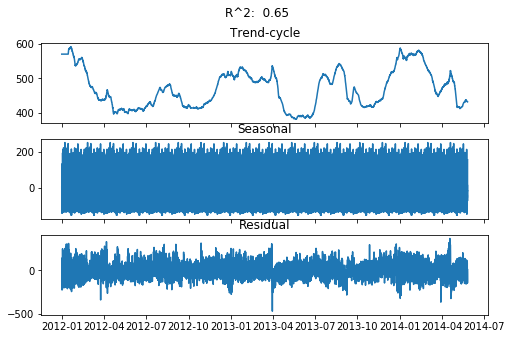

29


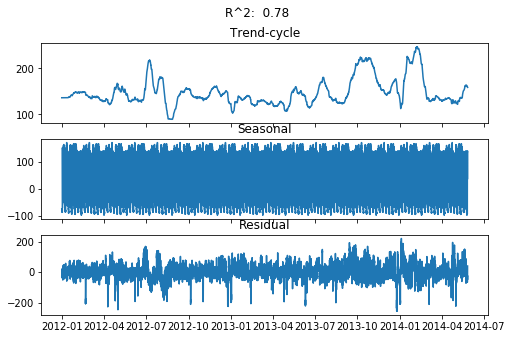

30


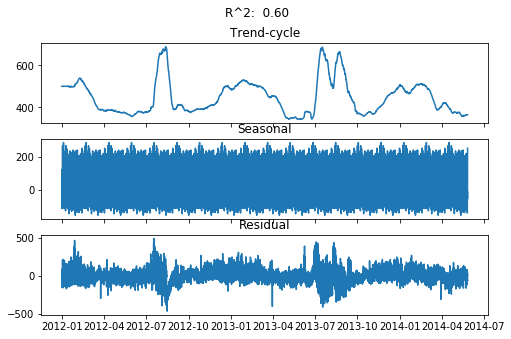

31


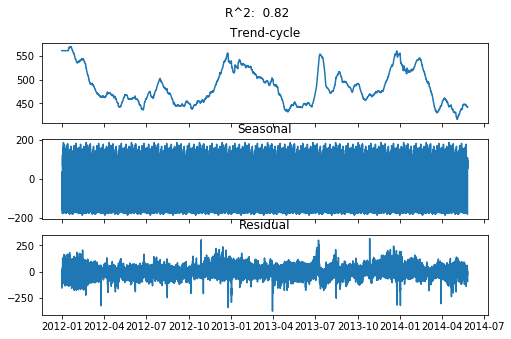

32


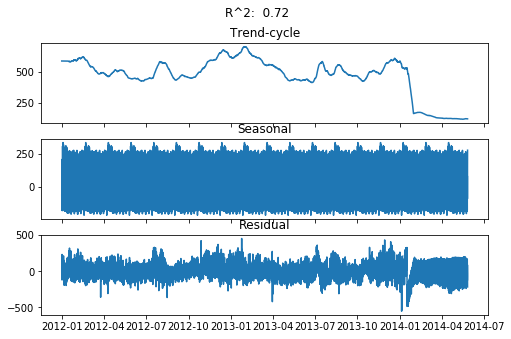

33


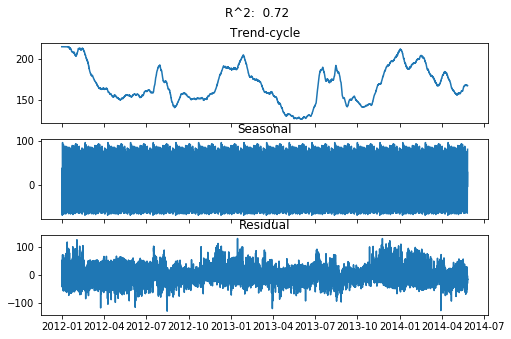

34


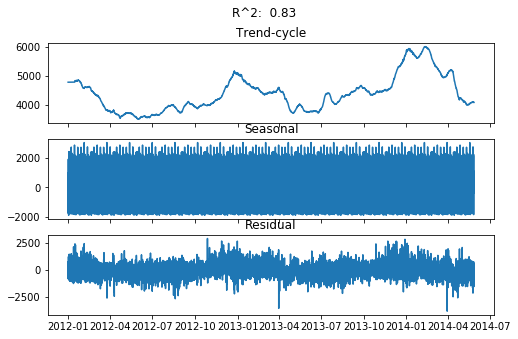

35


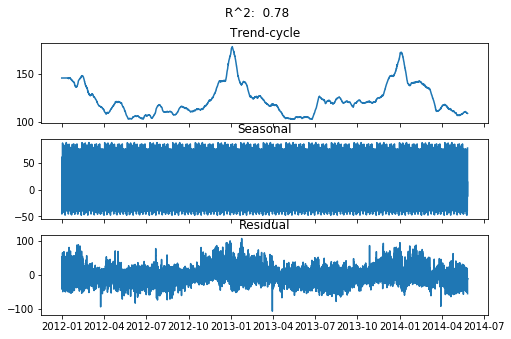

36


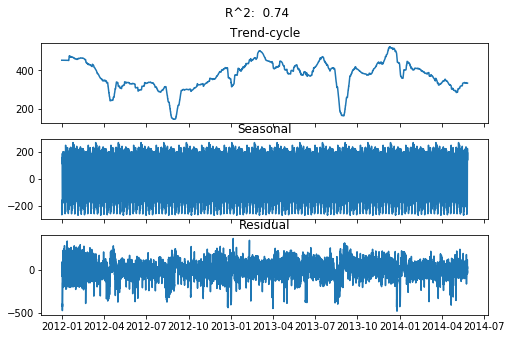

37


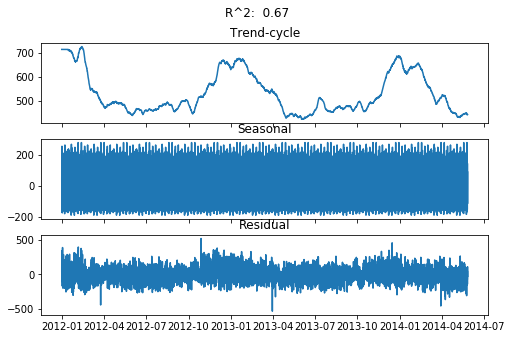

38


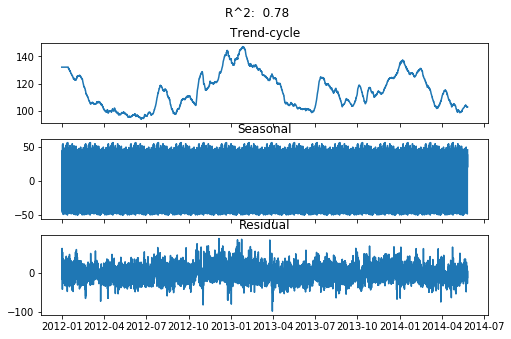

39


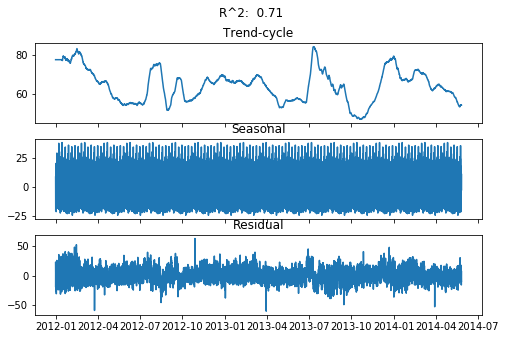

40


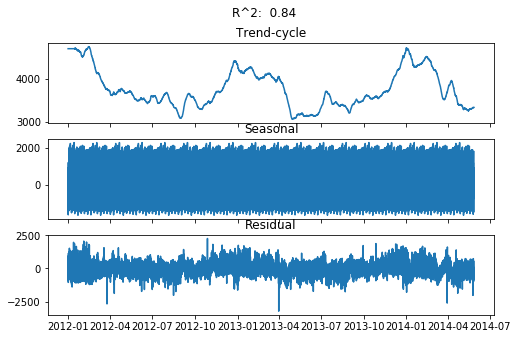

41


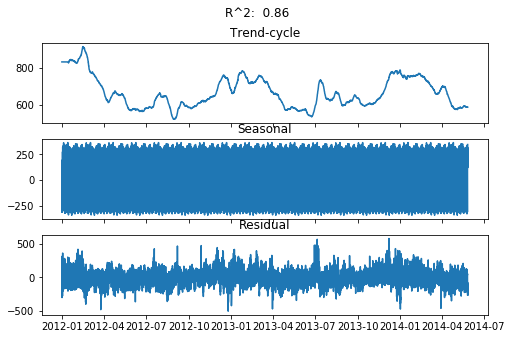

42


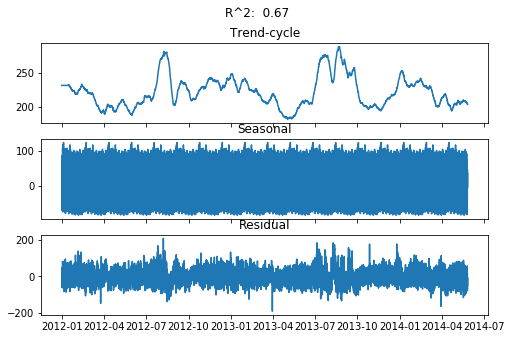

43


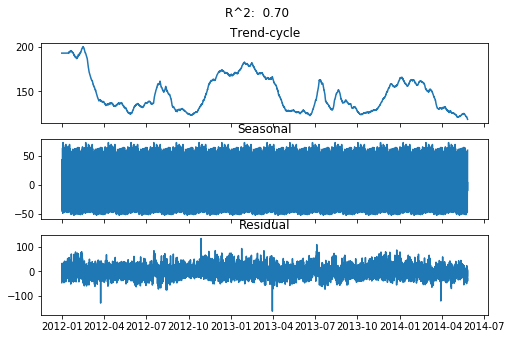

44


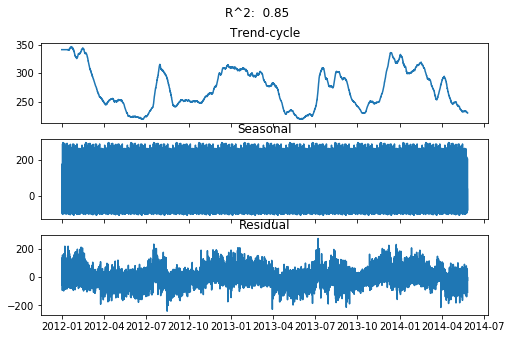

45


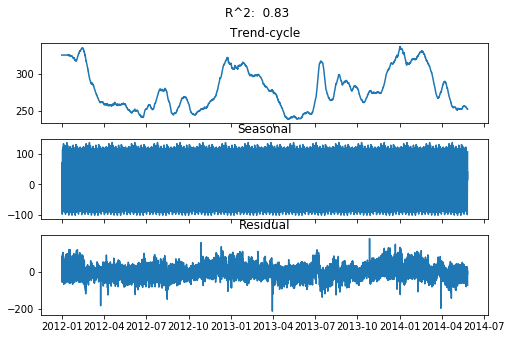

46


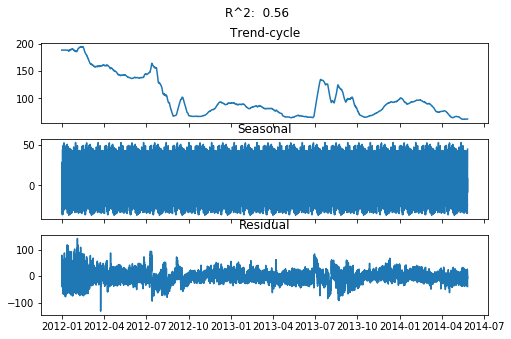

47


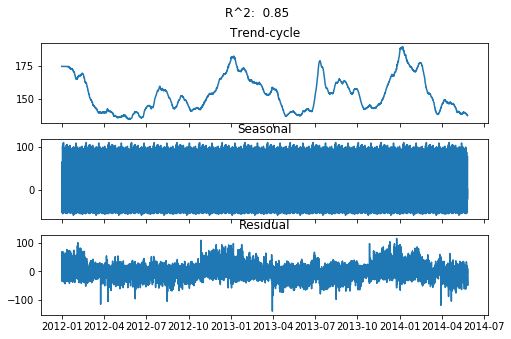

48


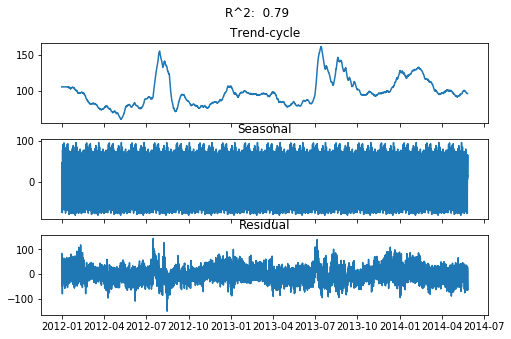

49


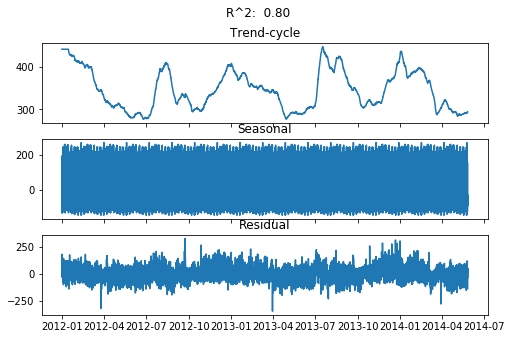

50


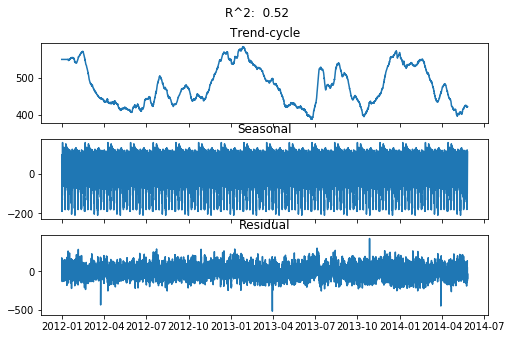

51


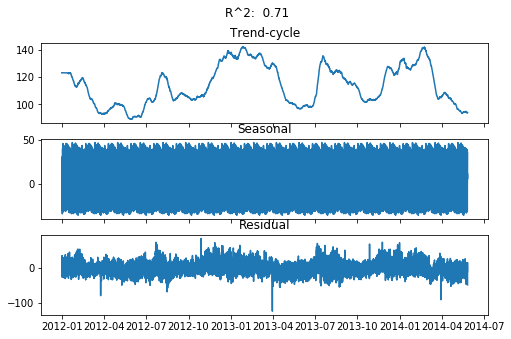

52


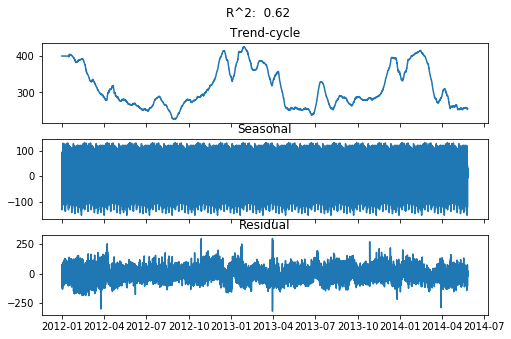

53


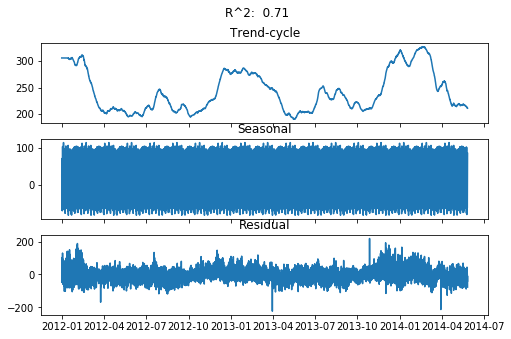

54


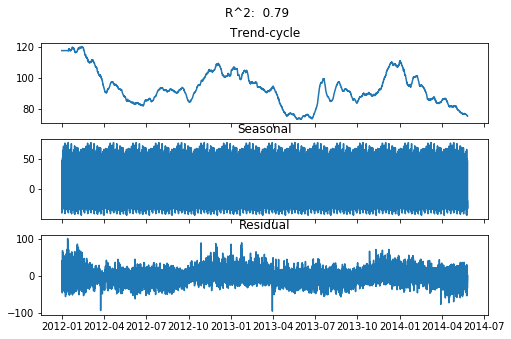

55


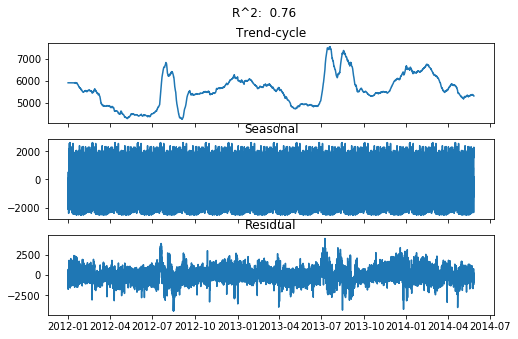

56


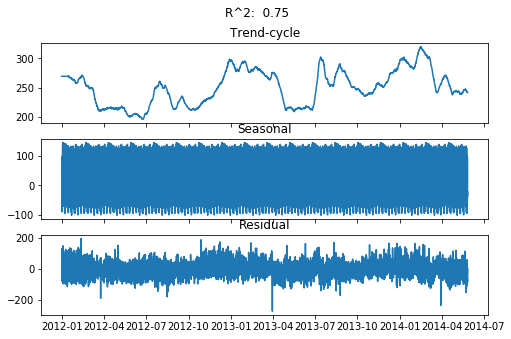

57


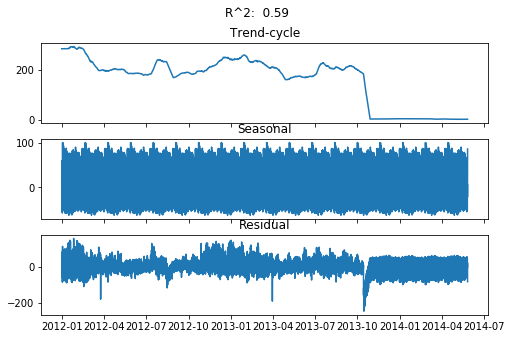

58


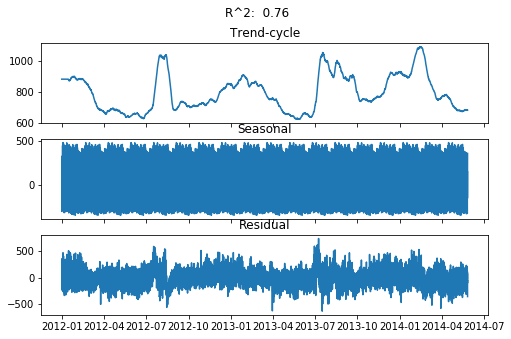

59


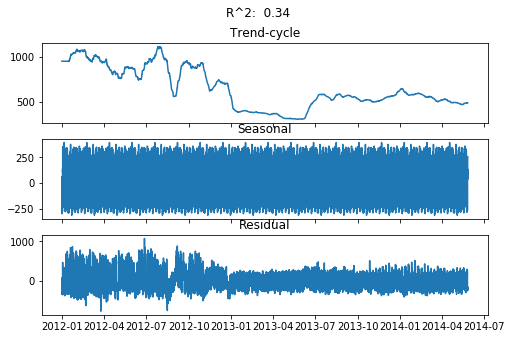

60


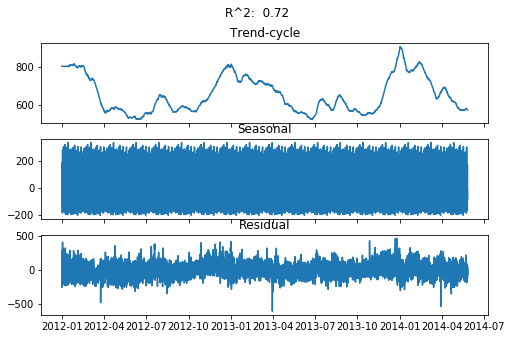

61


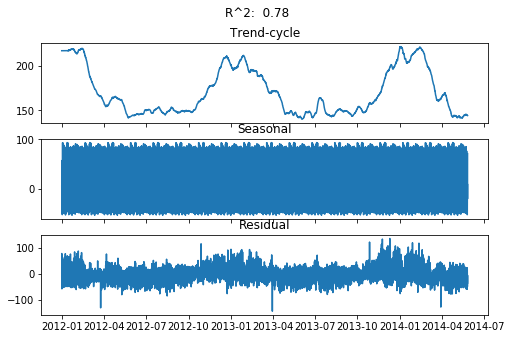

62


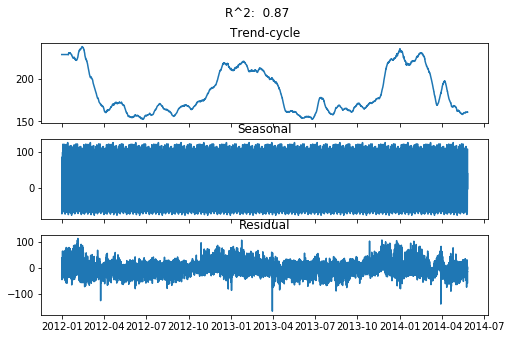

63


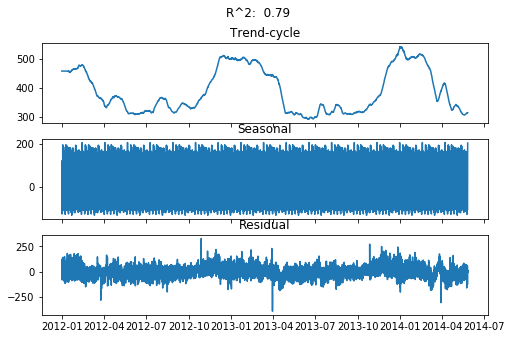

64


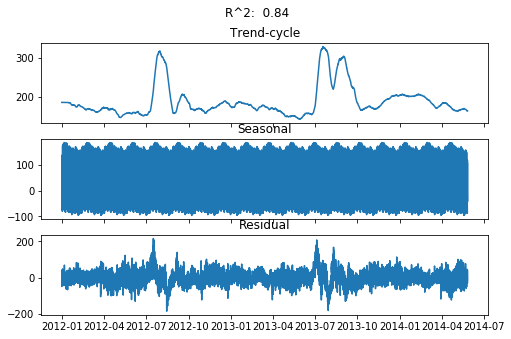

65


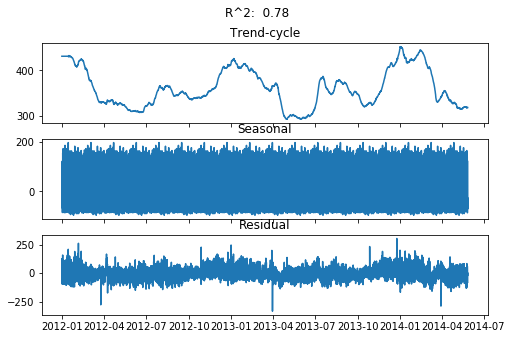

66


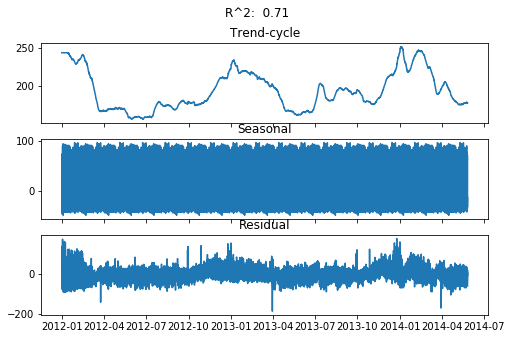

67


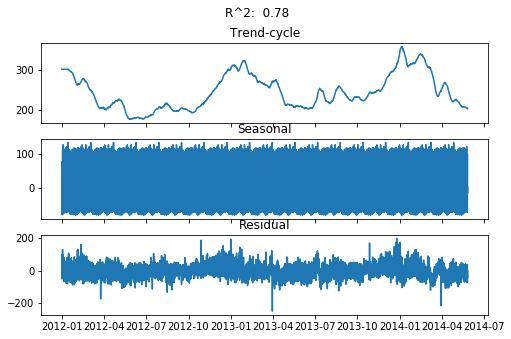

68


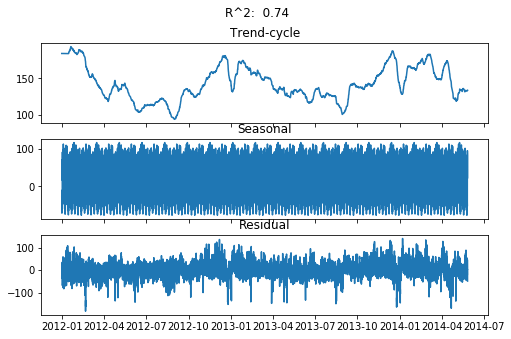

69


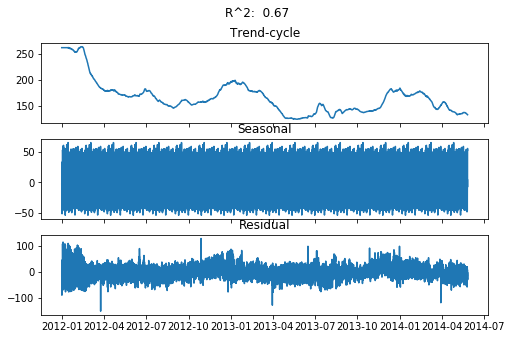

70


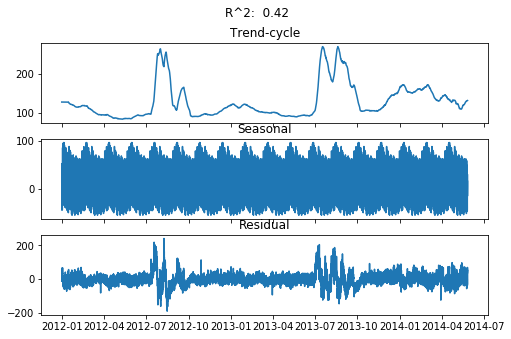

71


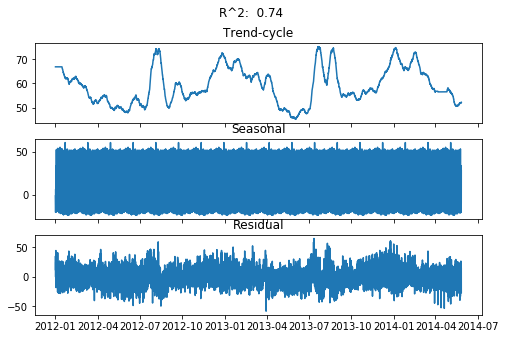

72


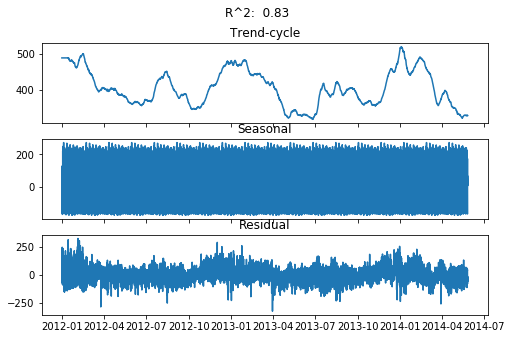

73


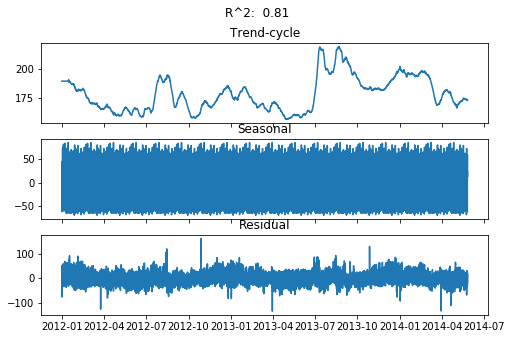

74


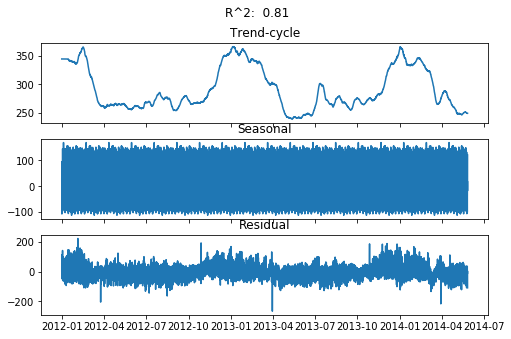

75


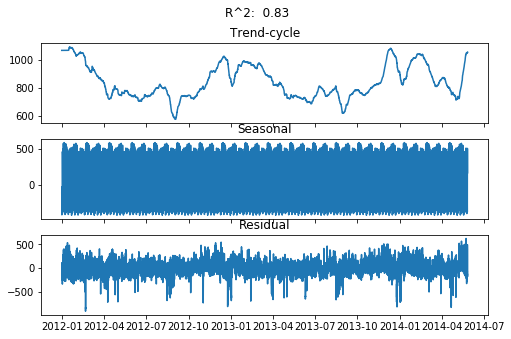

76


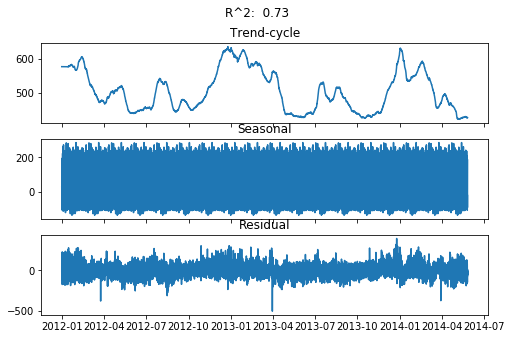

77


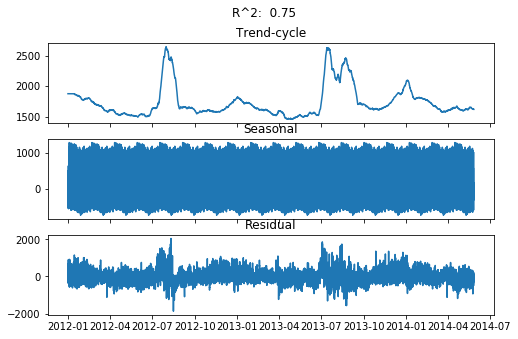

78


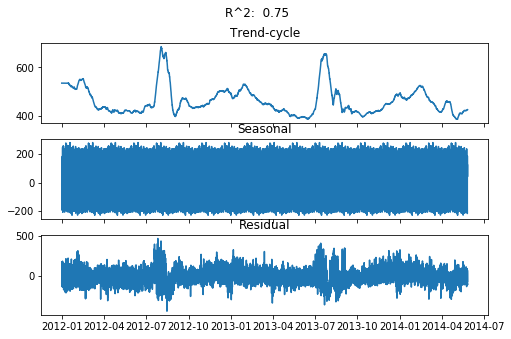

79


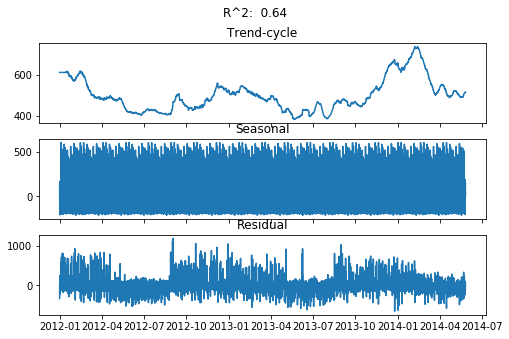

80


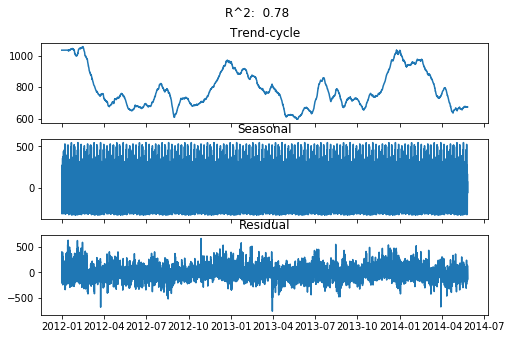

81


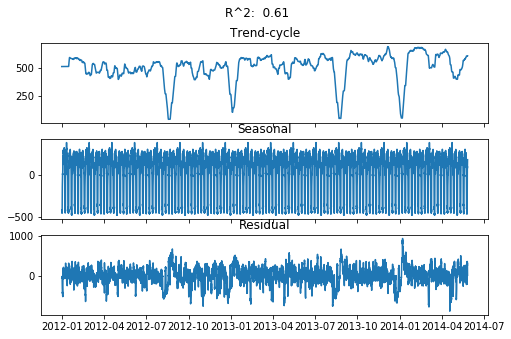

82


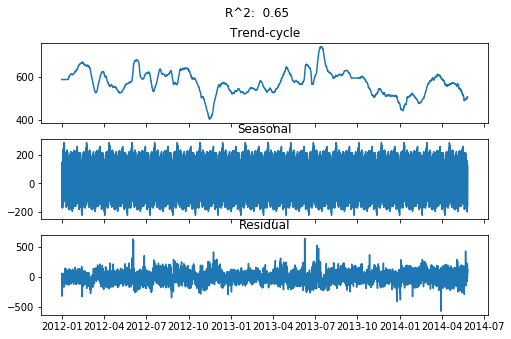

83


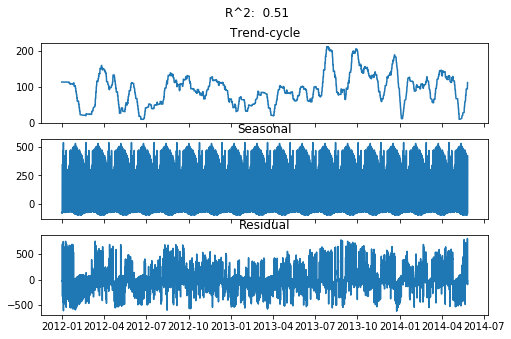

84


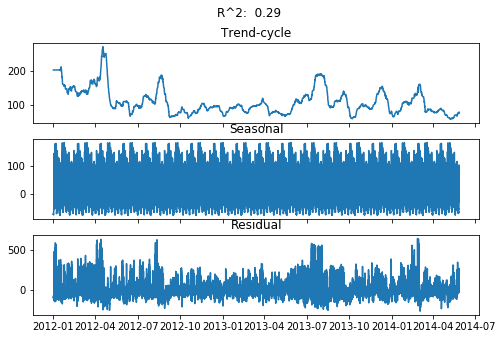

85


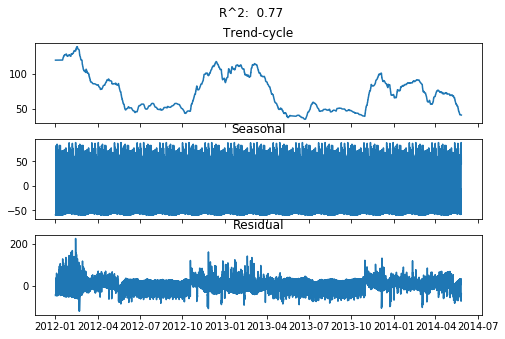

86


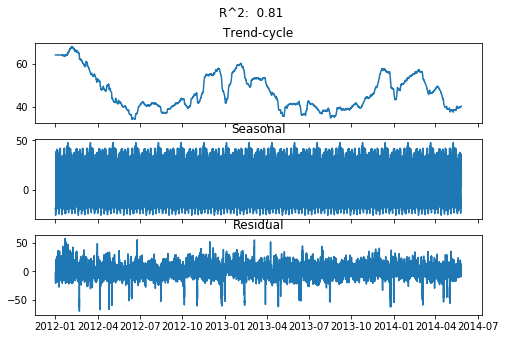

87


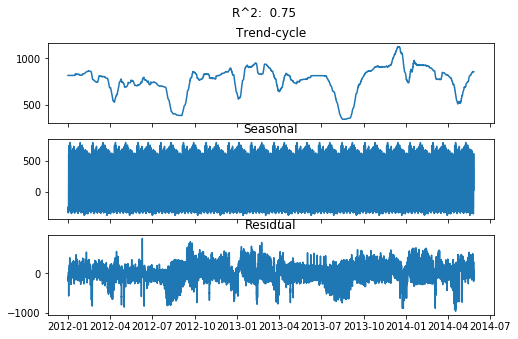

88


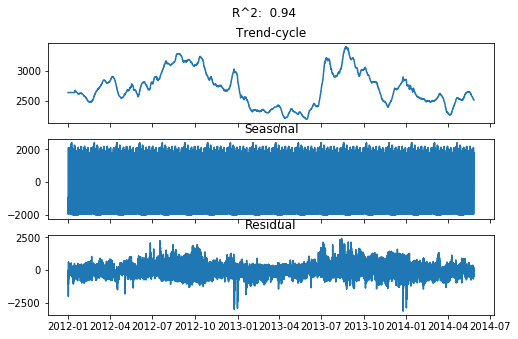

89


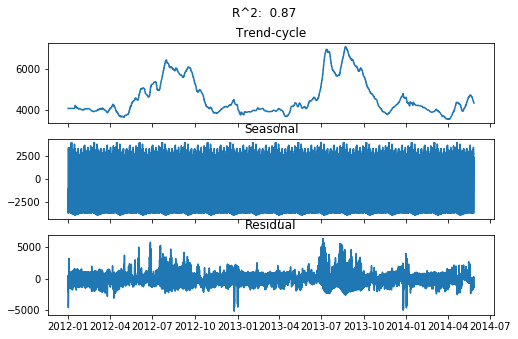

90


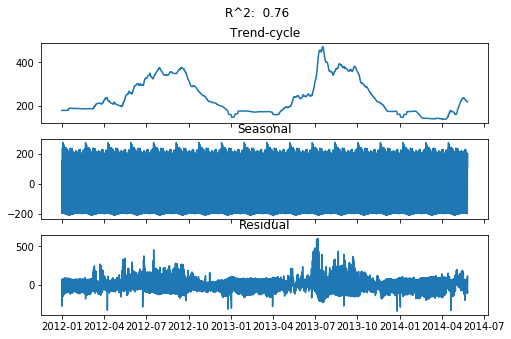

91


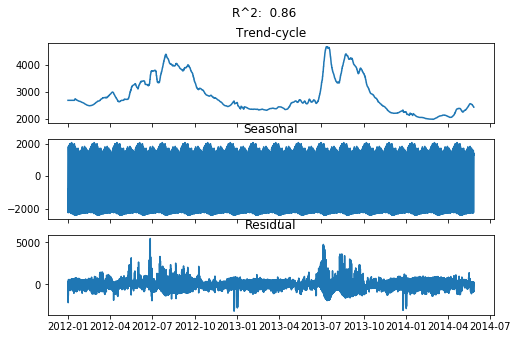

92


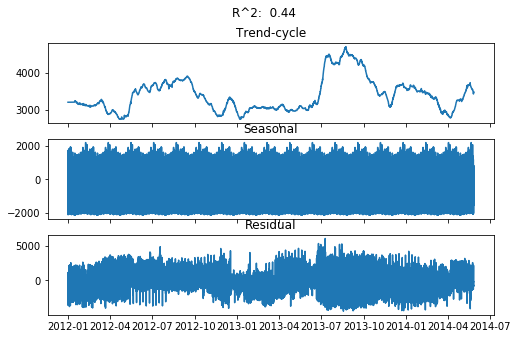

93


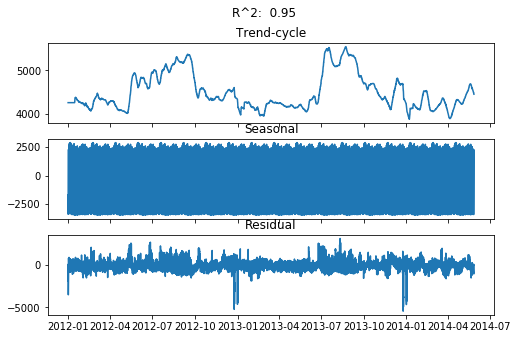

94


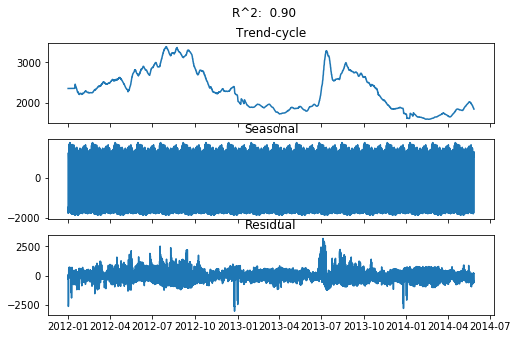

95


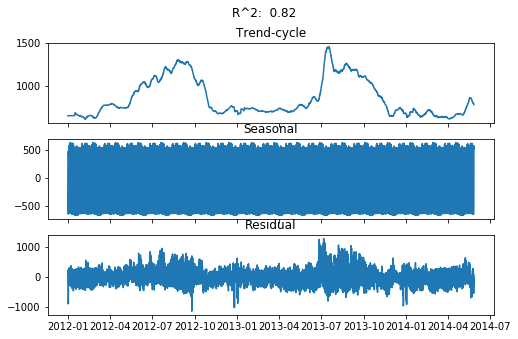

96


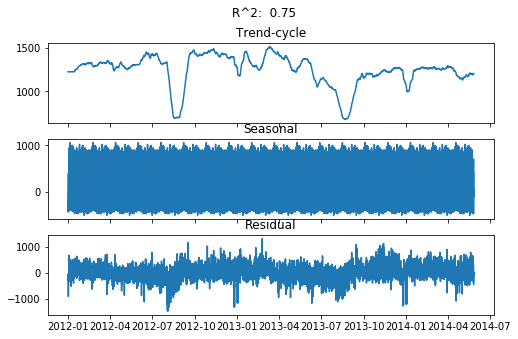

97


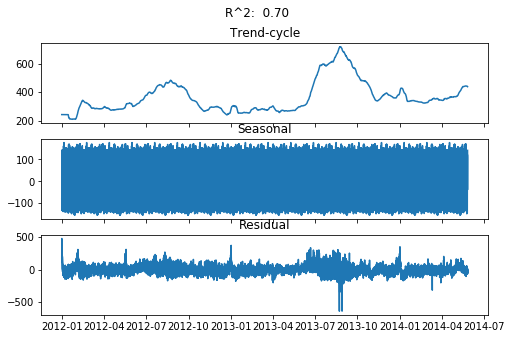

98


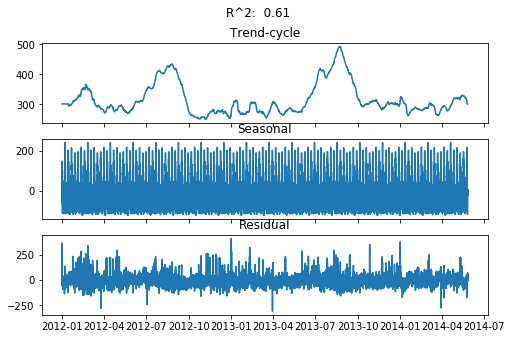

99


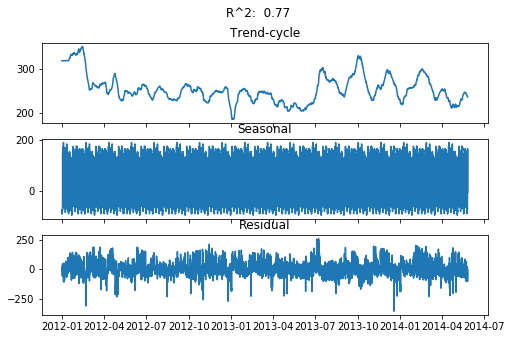

100


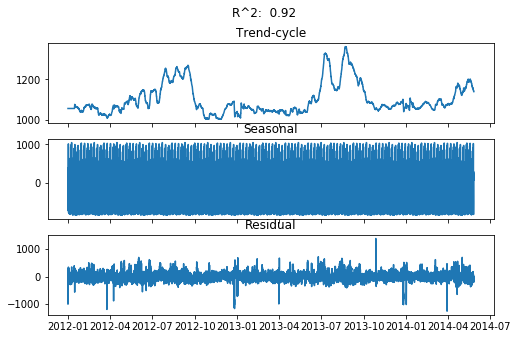

101


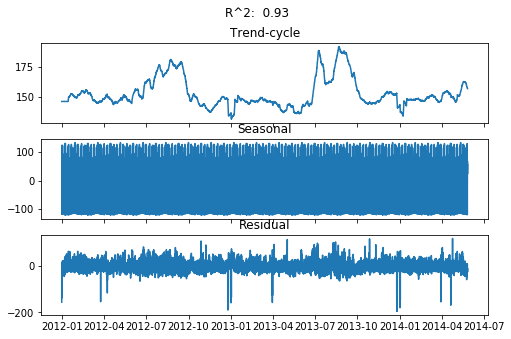

102


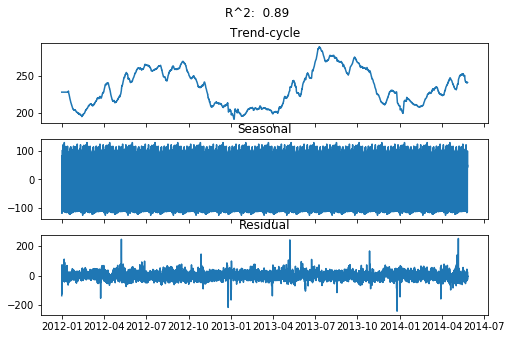

103


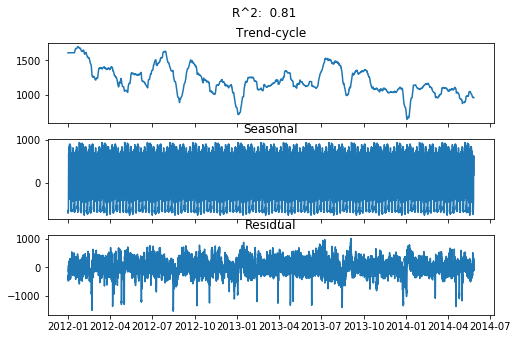

104


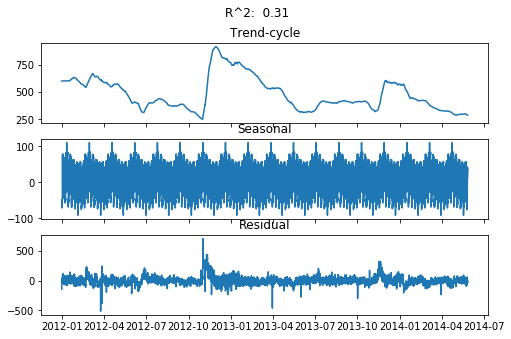

105


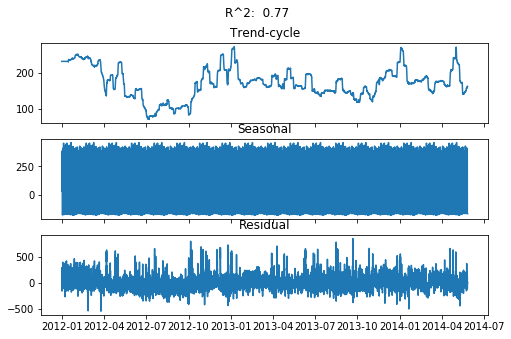

106


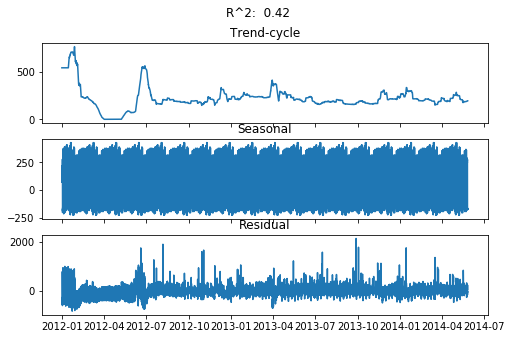

107


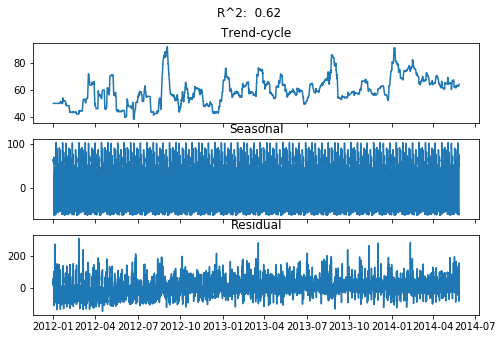

108


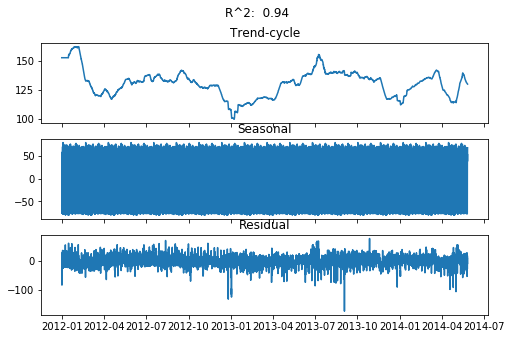

109


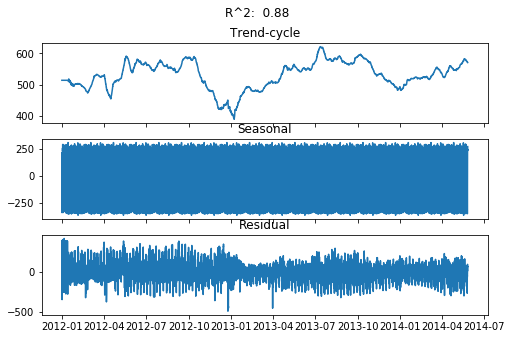

110


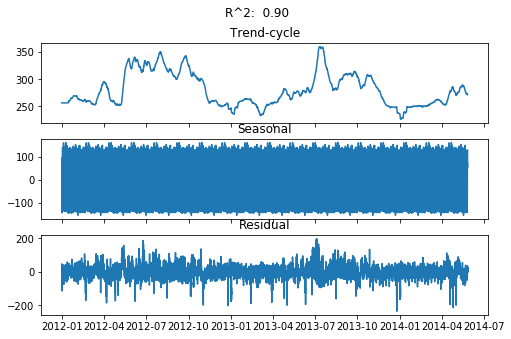

111


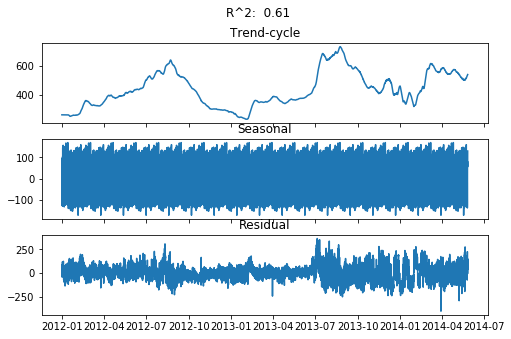

112


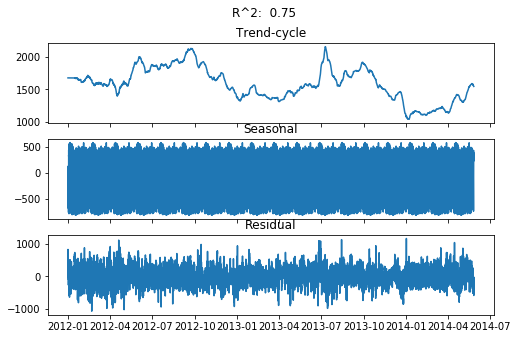

113


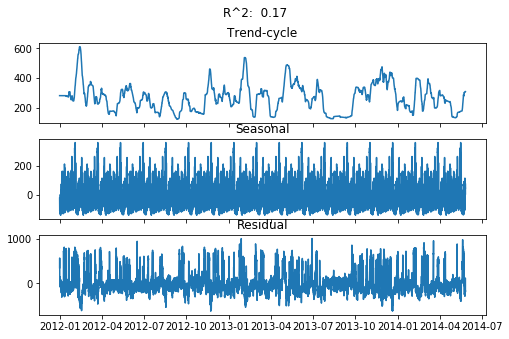

114


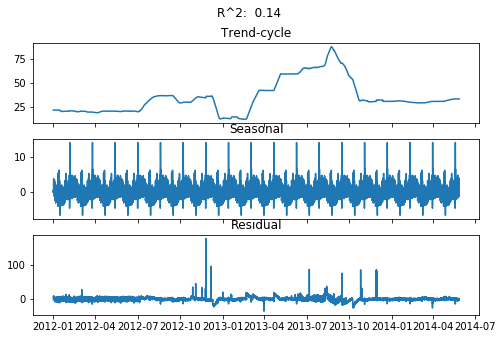

115


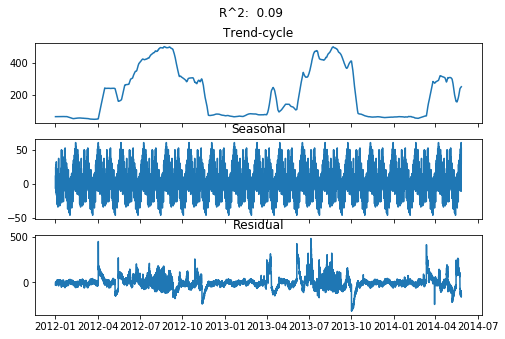

116


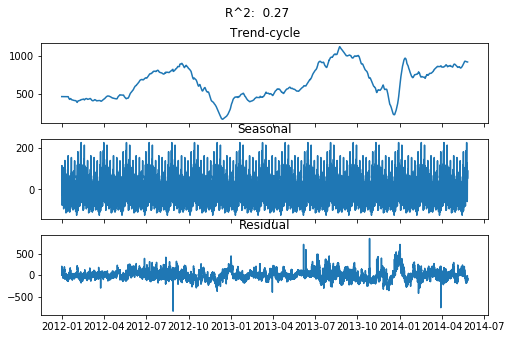

117


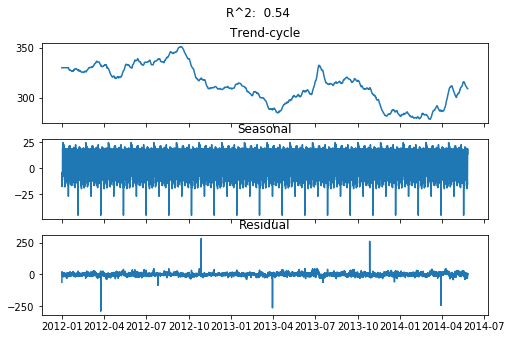

118


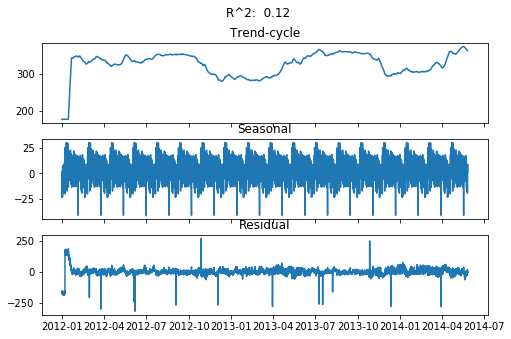

119


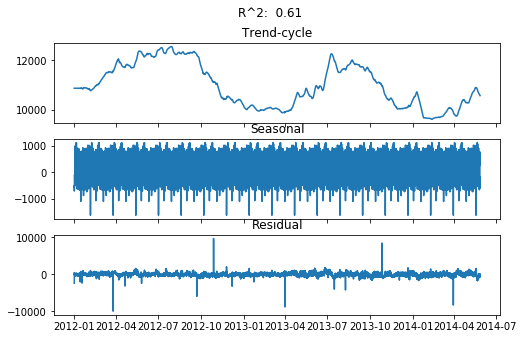

120


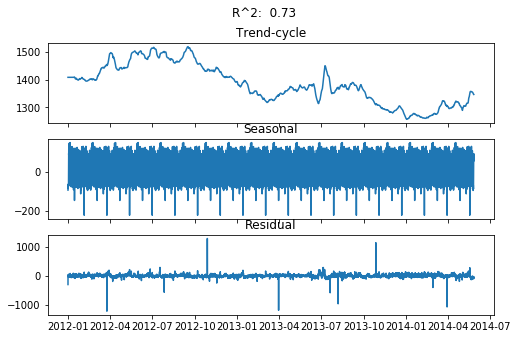

121


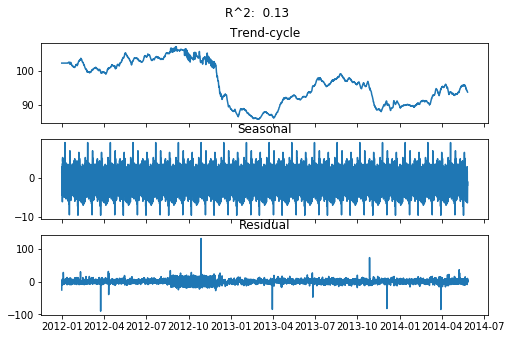

122


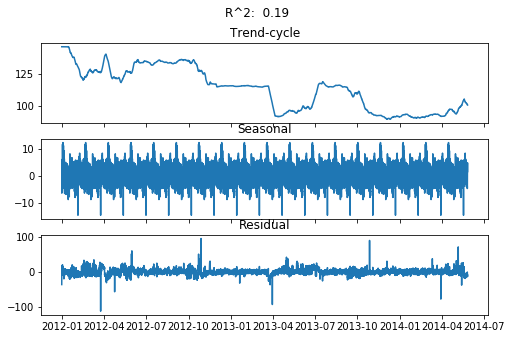

123


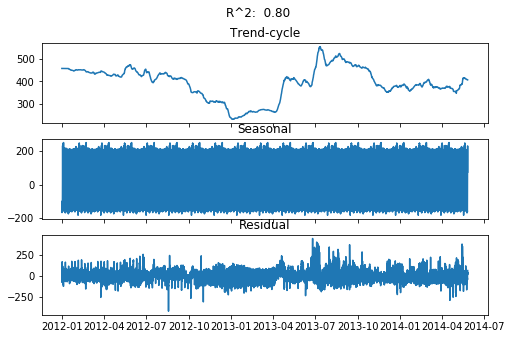

124


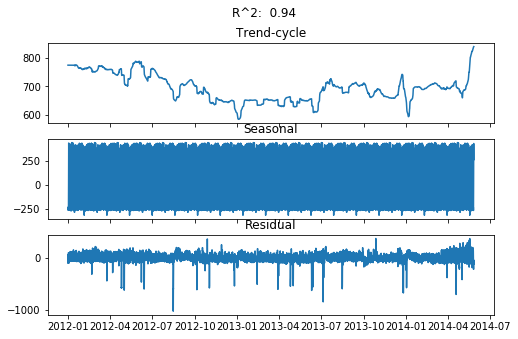

125


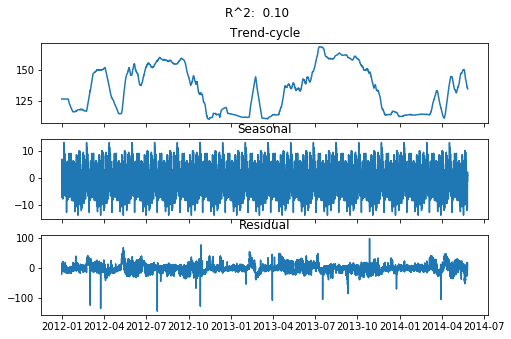

126


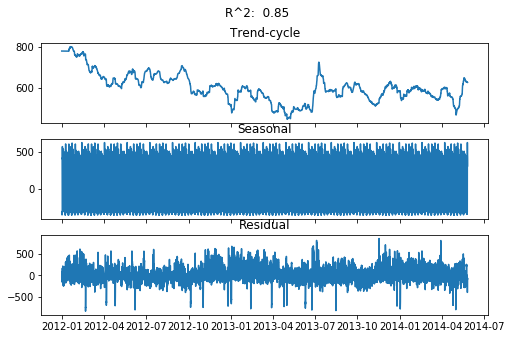

127


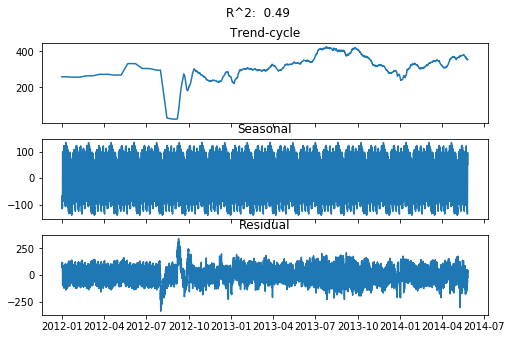

128


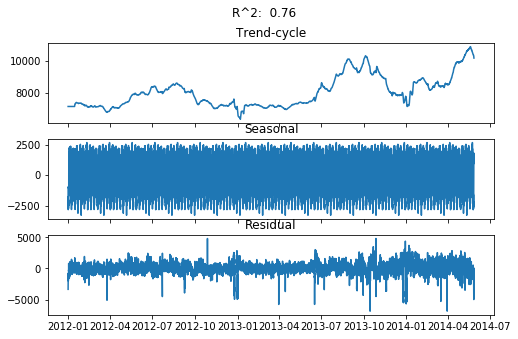

129


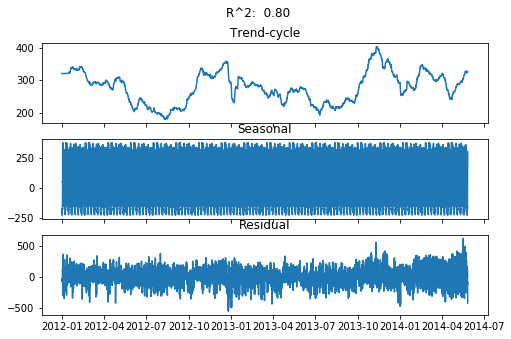

130


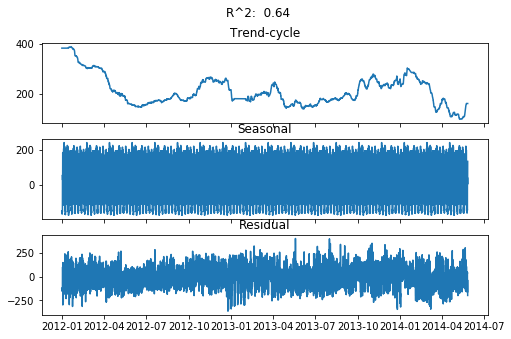

131


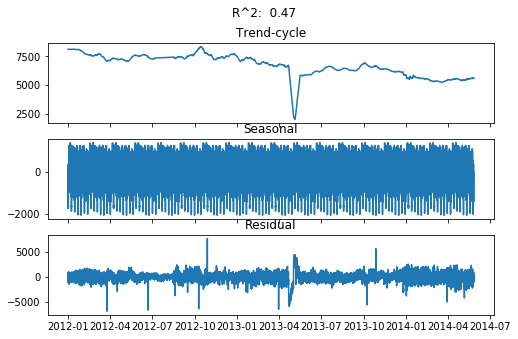

132


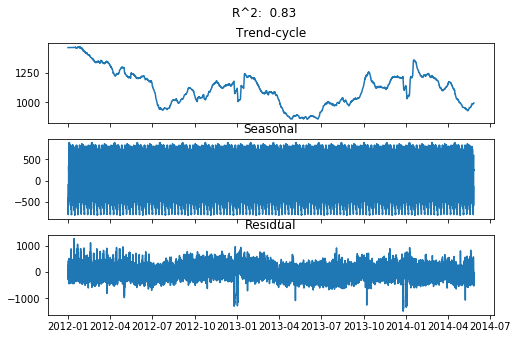

133


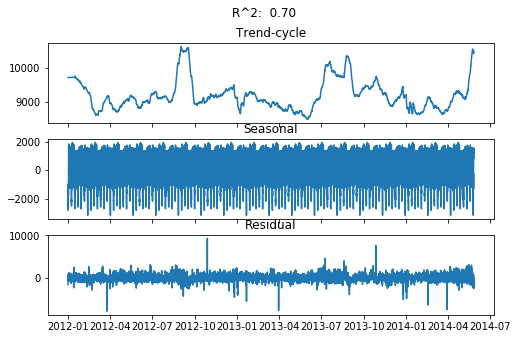

134


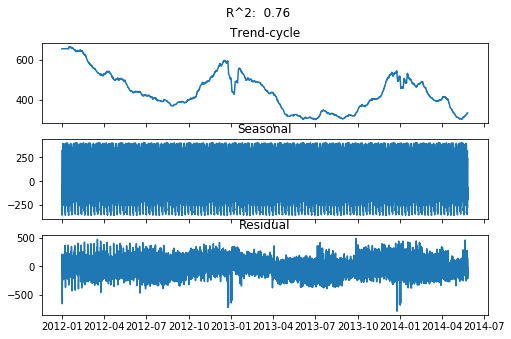

135


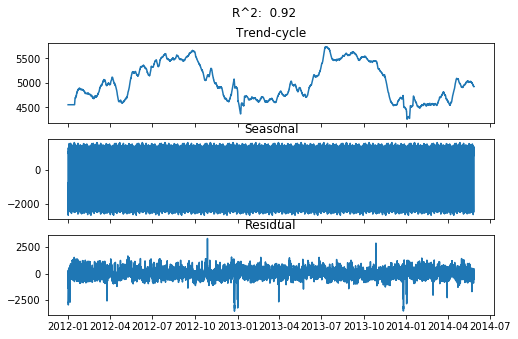

136


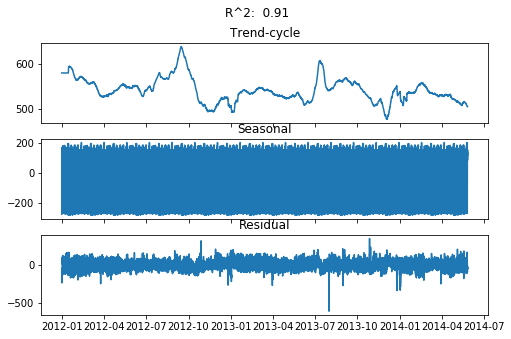

137


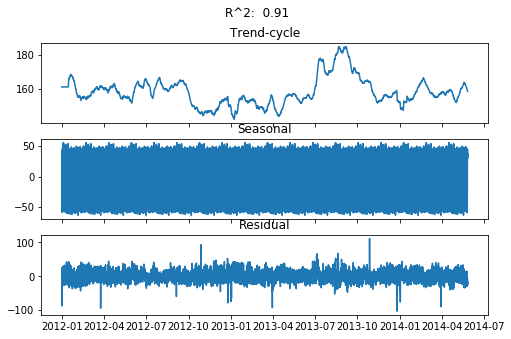

138


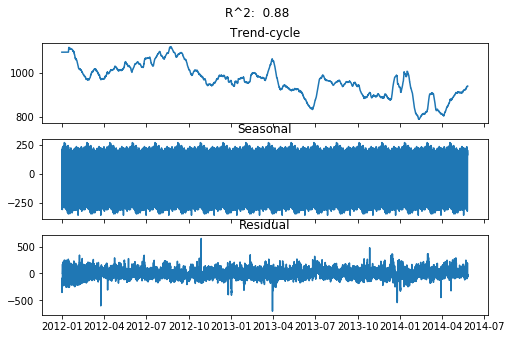

139


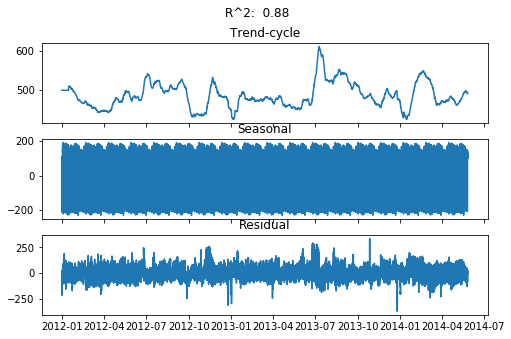

140


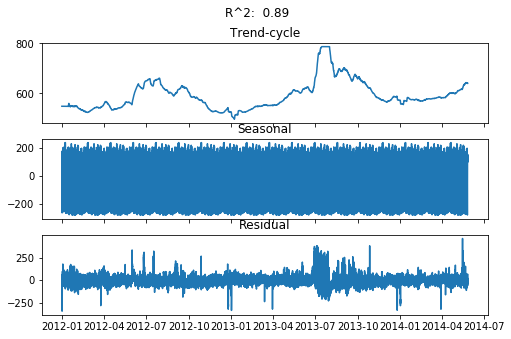

141


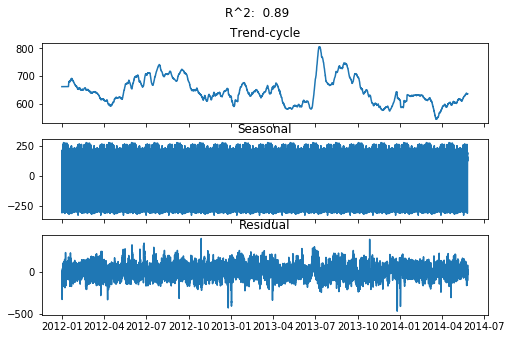

142


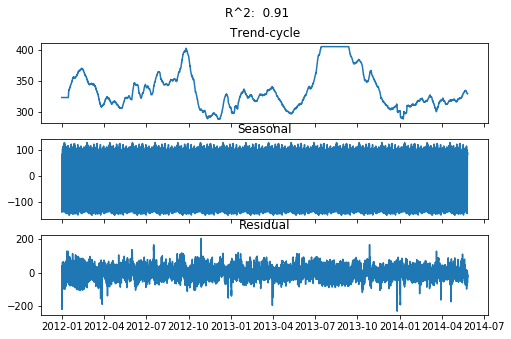

143


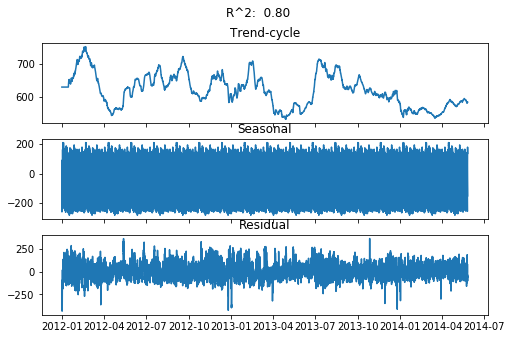

144


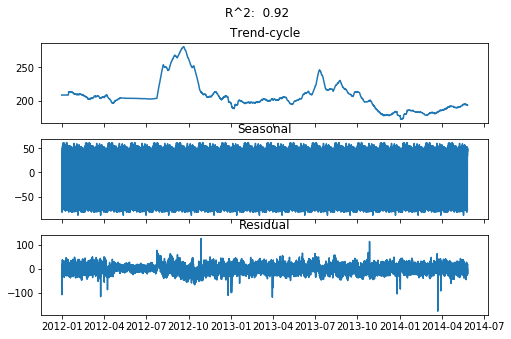

145


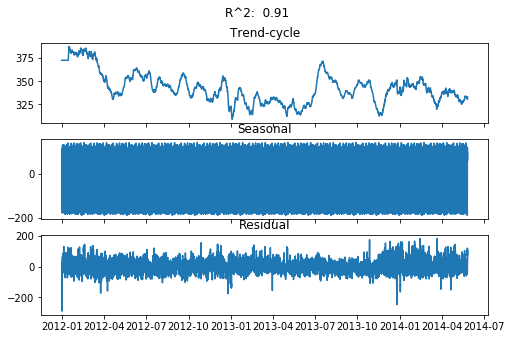

146


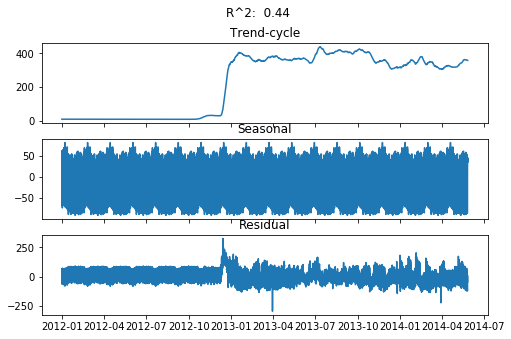

147


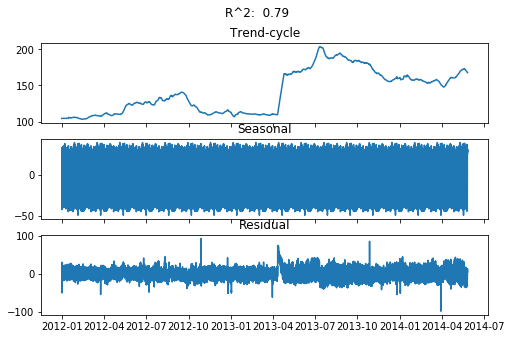

148


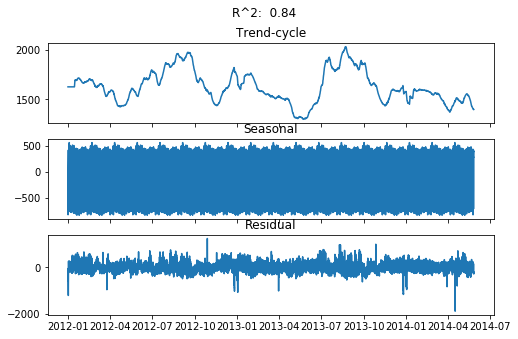

149


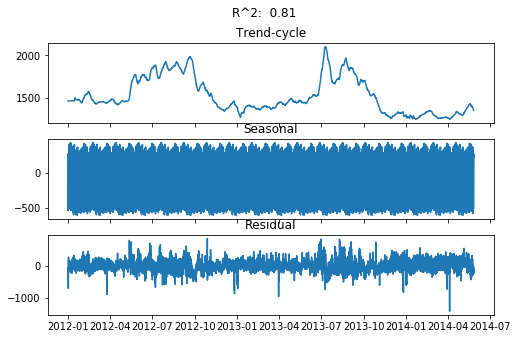

150


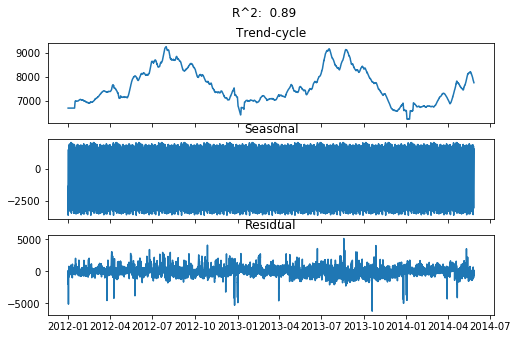

151


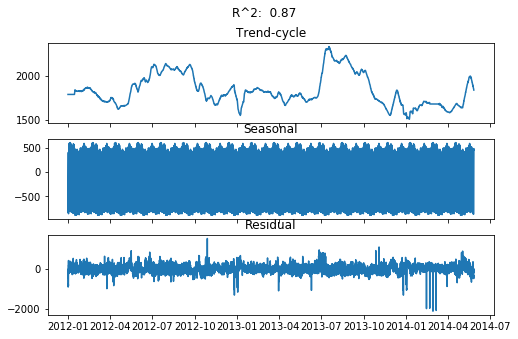

152


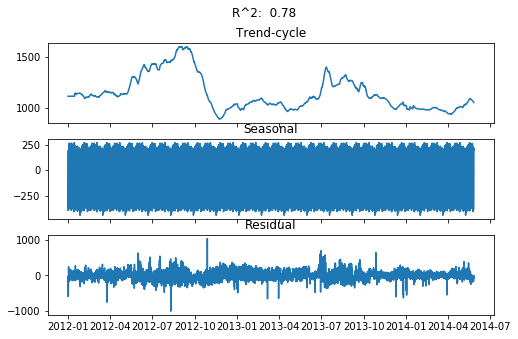

153


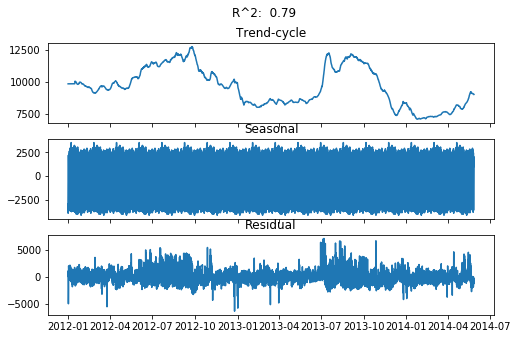

154


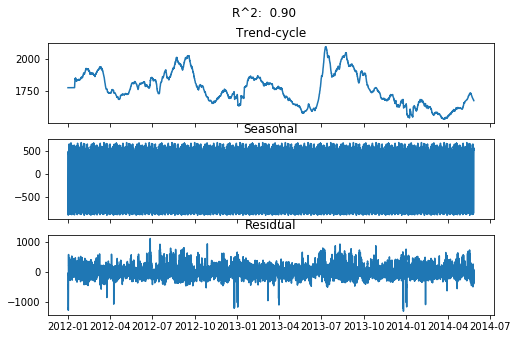

155


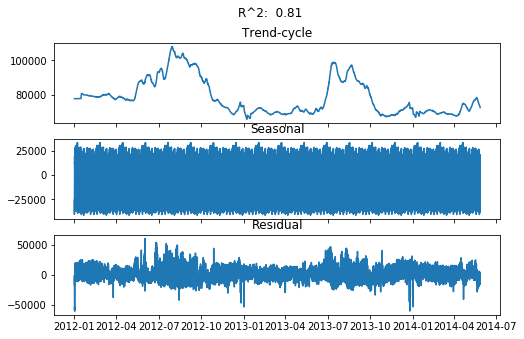

156


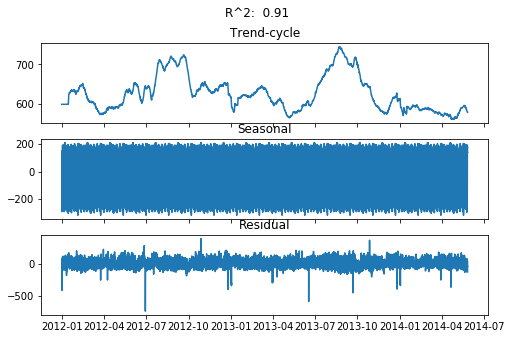

157


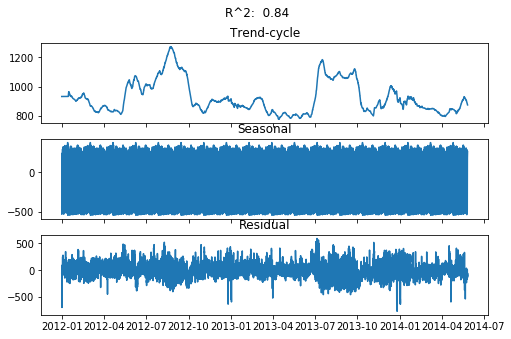

158


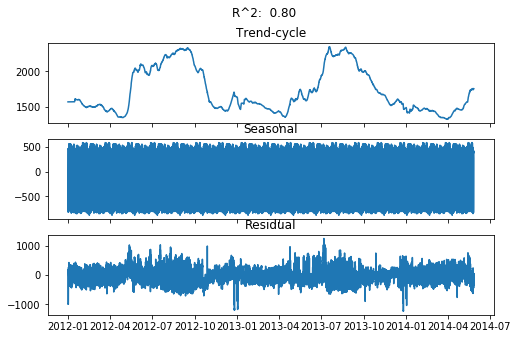

159


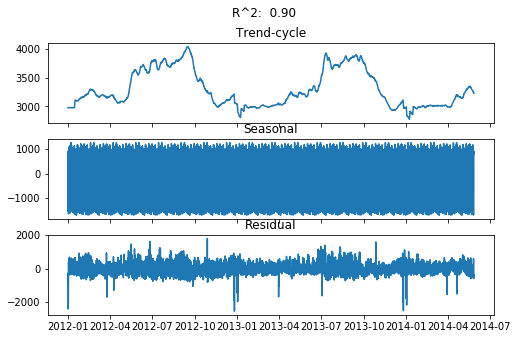

160


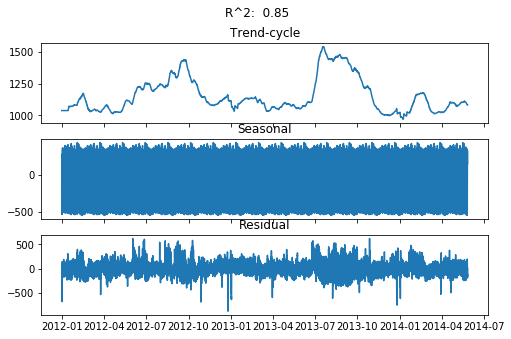

161


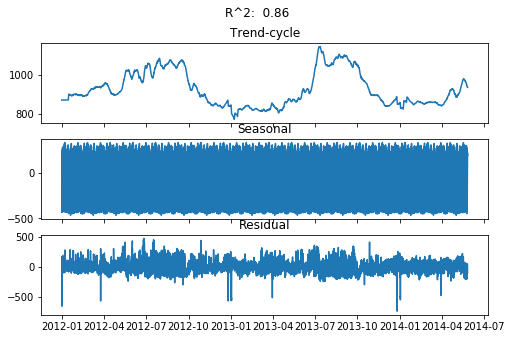

162


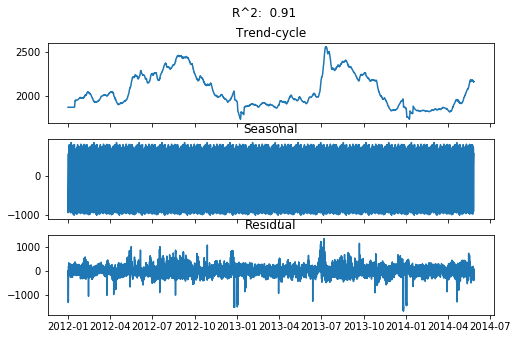

163


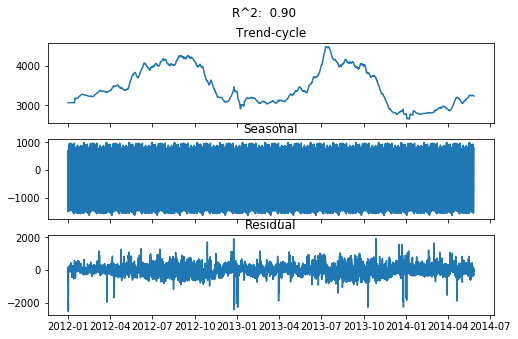

164


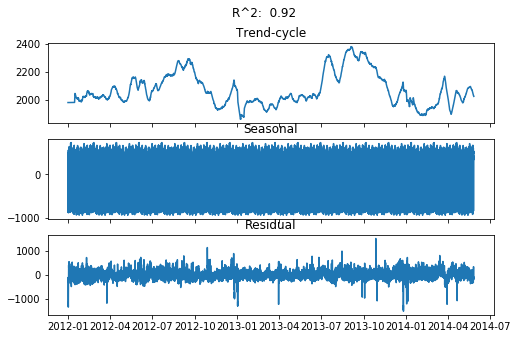

165


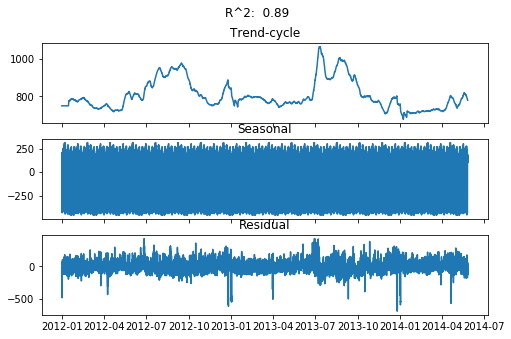

166


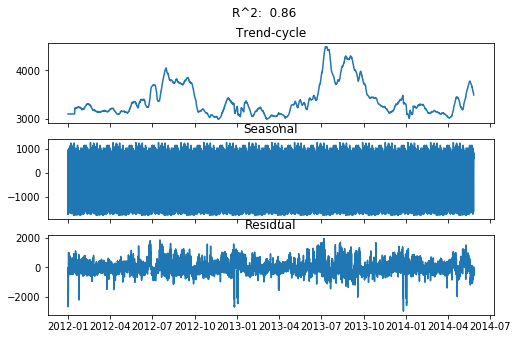

167


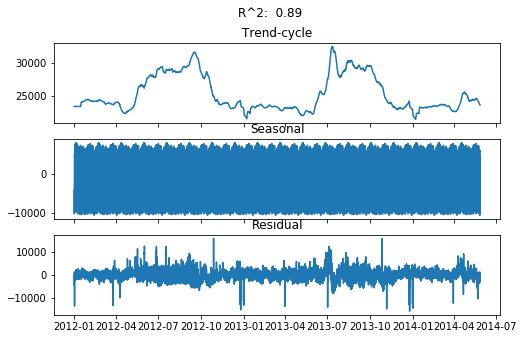

168


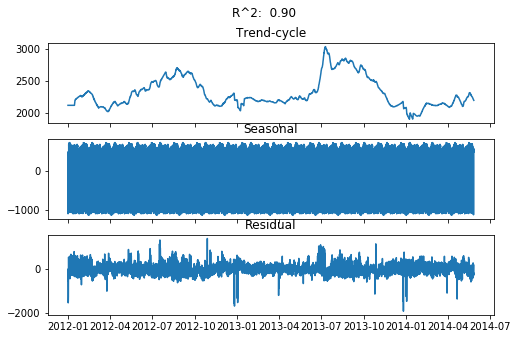

169


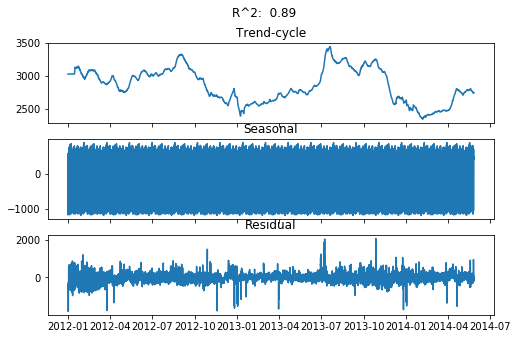

170


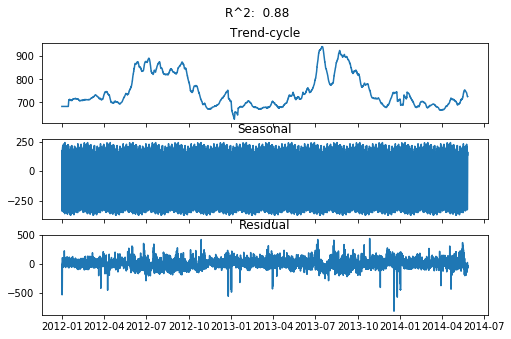

171


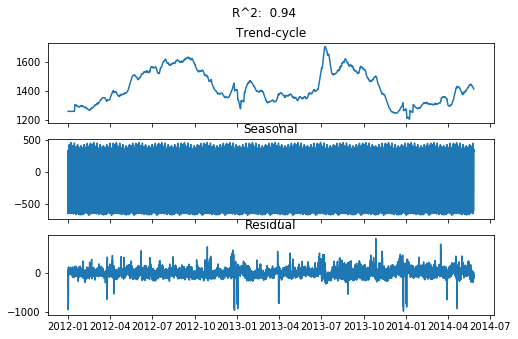

172


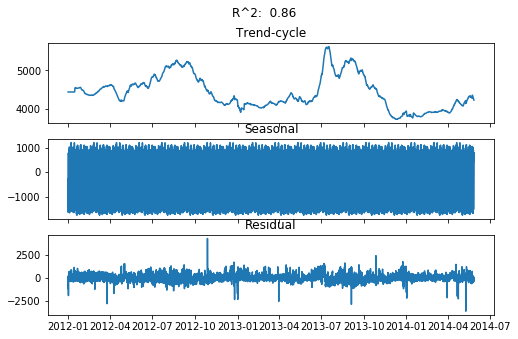

173


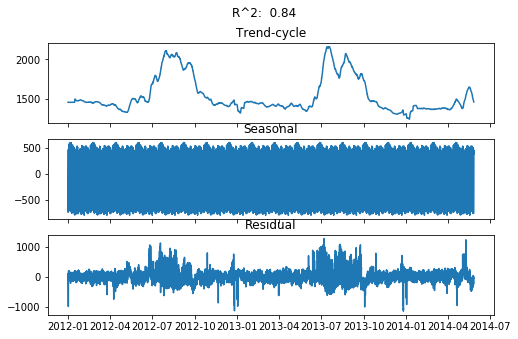

174


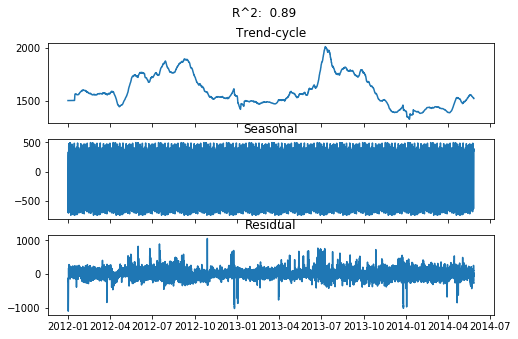

175


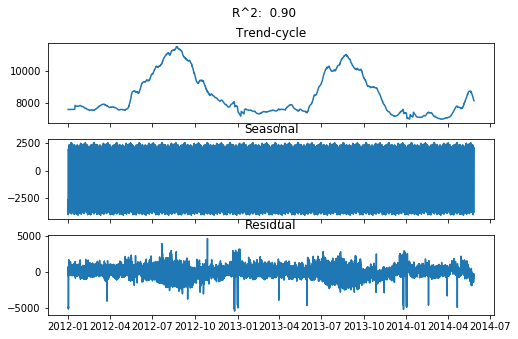

176


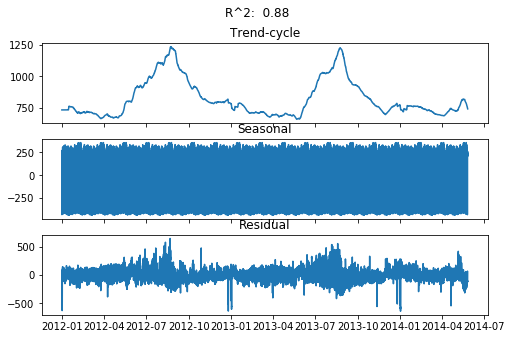

177


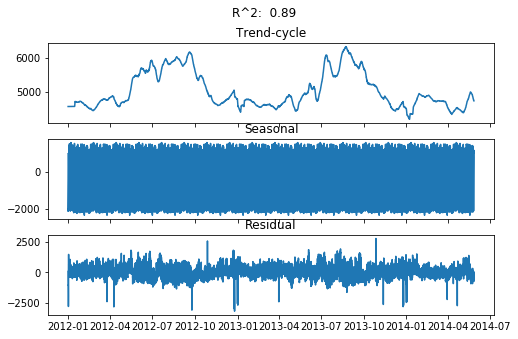

178


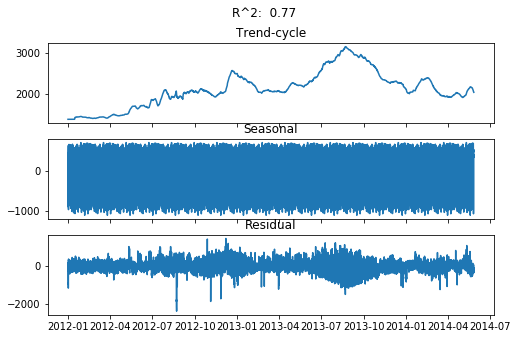

179


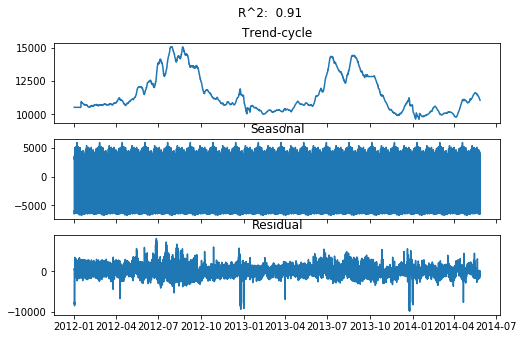

180


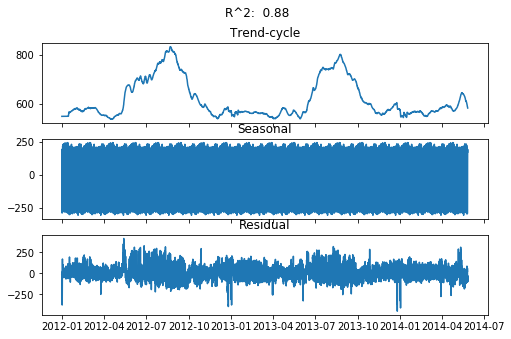

181


KeyboardInterrupt: 

In [48]:
for ix, d in enumerate(train_datas):
    df = to_pandas(d)
    print(ix)
    analyze_and_plot(df, 24 * 7)

## Compare tensor vs DFT/DCT in > 85% examples

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


3
3
3


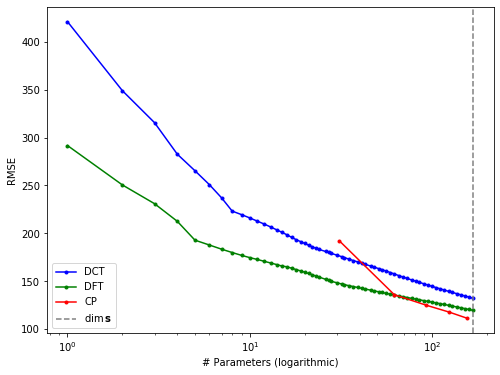

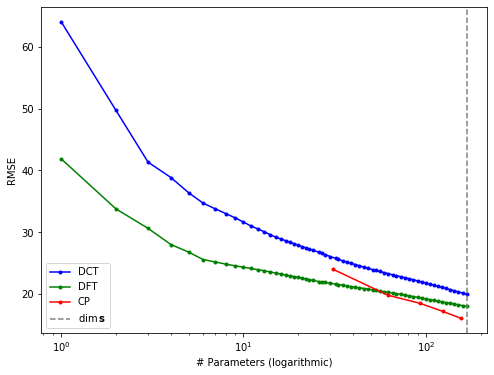

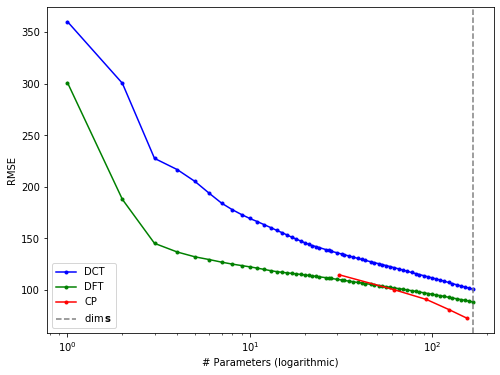

In [6]:
for idx in [100, 101, 171]:
    folds = [24, 7]
    _, ts = trend_cycle_decompose(
        to_pandas(train_datas[idx]), int(np.prod(folds) * 2)
    )

    extra = len(ts) % np.prod(folds)
    # test_data = ts.iloc[-extra:]
    ts = ts.iloc[:-extra]

    dct_errors, dft_errors, param_sweep = dct_dft_errors(ts, np.prod(folds), "log", 100)
    ten_errors, ten_params = tensor_errors(ts.values, folds=folds, ranks=list(range(1,6)))
    plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds)

3
3
3


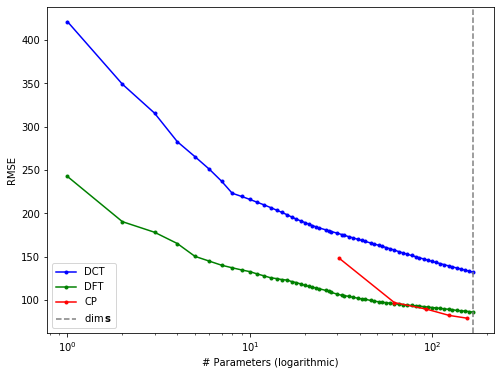

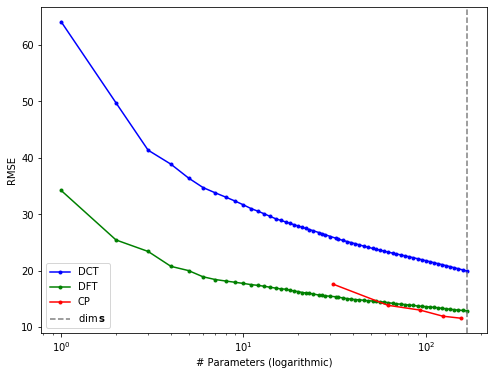

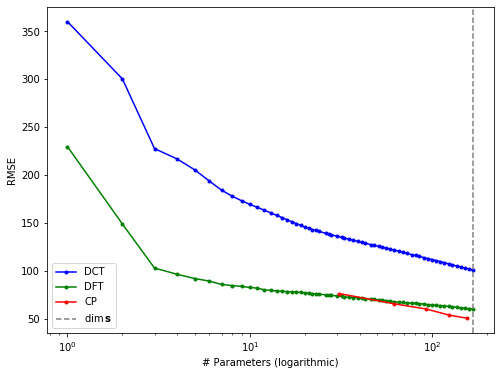

In [7]:
for idx in [100, 101, 171]:
    folds = [24, 7]
    _, ts = trend_cycle_decompose(
        to_pandas(train_datas[idx]), int(np.prod(folds) * 2)
    )

    extra = len(ts) % np.prod(folds)
    # test_data = ts.iloc[-extra:]
    ts = ts.iloc[:-extra]

    dct_errors, dft_errors, param_sweep = dct_dft_errors(ts, np.prod(folds), "log", 100, error_fn=mad)
    ten_errors, ten_params = tensor_errors(ts.values, folds=folds, ranks=list(range(1,6)), error_fn=mad)
    plot_comparison(dct_errors, dft_errors, ten_params, ten_errors, param_sweep, folds)